In [2]:
import cPickle
import string
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import gc
import math
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgbfir
from sklearn.metrics import r2_score


import model_eval

%matplotlib inline


DATA_TRAIN_PATH = '../input/train.csv'
DATA_TEST_PATH = '../input/test.csv'
LIN_DATA_TRAIN_PATH = '../input/lin_train.csv'
LIN_DATA_TEST_PATH = '../input/lin_test.csv'
IMG_PATH = '../images/'

### These variables perform better with OHE
ohe_list = ['cat73', 'cat93', 'cat112']

### These dicts are to re-encode cat112 to state abbreviations
swap_to_num = {'cat112': {'A': 0, 'AA': 25, 'AB': 26, 'AC': 27, 'AD': 28,
'AE': 29, 'AF': 30, 'AG': 31, 'AH': 32, 'AI': 33, 'AJ': 34, 'AK': 35, 'AL': 36,
'AM': 37, 'AN': 38, 'AO': 39, 'AP': 40, 'AQ': 41, 'AR': 42, 'AS': 43, 'AT': 44,
'AU': 45, 'AV': 46, 'AW': 47, 'AX': 48, 'AY': 49, 'B': 1, 'BA': 50, 'C': 2,
'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11,
'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19,
'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24}}

swap_to_state = {'cat112': {0: 'AL', 1: 'AK', 2: 'AZ', 3: 'AR', 4: 'CA',
5: 'CO', 6: 'CT', 7: 'DE', 8: 'DC', 9: 'FL', 10: 'GA', 11: 'HI', 12: 'ID',
13: 'IL', 14: 'IN', 15: 'IA', 16: 'KS', 17: 'KY', 18: 'LA', 19: 'ME', 20: 'MD',
21: 'MA', 22: 'MI', 23: 'MN', 24: 'MS', 25: 'MO', 26: 'MT', 27: 'NE', 28: 'NV',
29: 'NH', 30: 'NJ', 31: 'NM', 32: 'NY', 33: 'NC', 34: 'ND', 35: 'OH', 36: 'OK',
37: 'OR', 38: 'PA', 39: 'RI', 40: 'SC', 41: 'SD', 42: 'TN', 43: 'TX', 44: 'UT',
45: 'VT', 46: 'VA', 47: 'WA', 48: 'WV', 49: 'WI', 50: 'WY'}}

### Helper functions
def convert_cat_to_num(data):
    translation = list(string.ascii_uppercase)[:-1]
    for elem_i in translation[:13]:
        for elem_j in translation[:25]:
            translation.append(elem_i + elem_j)
    for i in range(len(translation)):
        data.replace(translation[i], i, inplace=True)
    data.replace('ZZ', -1, inplace=True)
    return


### Read the data in and prepare
log_y = 436.28279443805883
train = pd.read_csv(LIN_DATA_TRAIN_PATH, dtype={'id': np.int32})
train = train.replace(swap_to_num).replace(swap_to_state)
train = pd.get_dummies(train, columns=ohe_list)
convert_cat_to_num(train)
train['logloss'] = np.log(train['loss']+log_y)
test = pd.read_csv(LIN_DATA_TEST_PATH, dtype={'id': np.int32})
test = test.replace(swap_to_num).replace(swap_to_state)
test = pd.get_dummies(test, columns=ohe_list)
convert_cat_to_num(test)
ntrain = train.shape[0]
ntest = test.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True)
num_feats = [feat for feat in test.columns if 'cont' in feat]
#lin_feats = [feat for feat in test.columns if 'lin' in feat]
#for col in lin_feats:
#    train[col] = train[col]/float(train_test[col].max())

cat_feats = [feat for feat in test.columns if 'cat' in feat]
prob_ordered=[]
for elem in cat_feats:
    if train_test[elem].nunique()!=train_test[elem].max()+1:
        prob_ordered.append(elem)

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [3]:
folds = 5
early_stop = 40
### Through HyperOpt, found best log_y value to be 
log_y = 436.28279443805883

score, clf = model_eval.xgb_quick_eval(train.drop(['loss','logloss'], axis=1),
    np.log(train['loss']+log_y), folds=folds, log_y=log_y, booster='gbtree', early_stop=early_stop)

[0]	train-mae:6.67228	eval-mae:6.67361
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 40 rounds.
[200]	train-mae:0.315754	eval-mae:0.335561
[400]	train-mae:0.303212	eval-mae:0.334762
Stopping. Best iteration:
[428]	train-mae:0.301194	eval-mae:0.33456

Average eval-MAE: 1147.397123

Means: actual=3037.33768512, predicted=2723.27709961
Medians: actual=2115.56987581, predicted=2058.47949219
 Time taken: 2.0 min and 23.73 sec


In [6]:
xgbfir.saveXgbFI(clf, MaxInteractionDepth=7)

In [128]:
def plot_cont_feature_bins(bins, features, y='logloss', lin=True, transform=None, outliers=[]):
    for col in features:
        df=train.loc[:,[col, y]]
        if transform != None:
            df[col] = transform(df[col])
        df['binned_'+col] = pd.cut(df[col], bins=bins)
        binned = df.groupby(by='binned_'+col)
        binned = binned.mean()
        binned['INDEX'] = np.arange(binned.shape[0])
        clean_binned = binned.dropna()
        if outliers != []:
            clean_binned = clean_binned.drop(clean_binned.index[outliers], 0)
        slope, intercept, r_value, p_value, std_err = \
            linregress(clean_binned.INDEX, clean_binned[y])
        
        if lin == True:
            df_lin = train.loc[:,['lin_'+col, y]]
            if transform != None:
                df_lin['lin_'+col] = transform(df_lin['lin_'+col])
            df_lin['binned_lin_'+col] = pd.cut(df_lin['lin_'+col], bins=bins)
            lin_binned = df_lin.groupby(by='binned_lin_'+col)
            lin_binned = lin_binned.mean()
            lin_binned['INDEX'] = np.arange(lin_binned.shape[0])
            clean_lin_binned = lin_binned.dropna()
            if outliers != []:
                clean_lin_binned = clean_lin_binned.drop(clean_lin_binned.index[outliers], 0)
            lin_slope, lin_intercept, lin_r_value, lin_p_value, lin_std_err = \
                linregress(clean_lin_binned.INDEX, clean_lin_binned[y])
        
        fig = plt.figure(figsize=(12,6))
        
        if lin == True:
            ax = fig.add_subplot(121)
            ax.plot(clean_binned.INDEX, clean_binned[y], marker='o', ms=4)
            ax.plot(clean_binned.INDEX, clean_binned.INDEX*slope+intercept)
            plt.title(col)
            ax.text(bins/2, clean_binned[y].min(), "R^2: {:.3f}".format(r_value**2))

            ax = fig.add_subplot(122)
            ax.plot(clean_lin_binned.INDEX, clean_lin_binned[y], marker='o', ms=4)
            ax.plot(clean_lin_binned.INDEX, clean_lin_binned.INDEX*lin_slope+lin_intercept)
            plt.title('lin_'+col)
            ax.text(bins/2, clean_lin_binned[y].min(), "R^2: {:.3f}".format(lin_r_value**2))
        
        else:
            ax = fig.add_subplot(111)
            ax.plot(clean_binned.INDEX, clean_binned[y], marker='o', ms=4)
            ax.plot(clean_binned.INDEX, clean_binned.INDEX*slope+intercept)
            plt.title(col)
            ax.text(bins/2, clean_binned[y].min(), "R^2: {:.3f}".format(r_value**2))

        plt.show()

Now plot the continuous features in bins of different sizes against loss and logloss. This will hopefully give some ideas to how to transform features. It will also show us some outliers that can be one hot encoded and removed from feature.

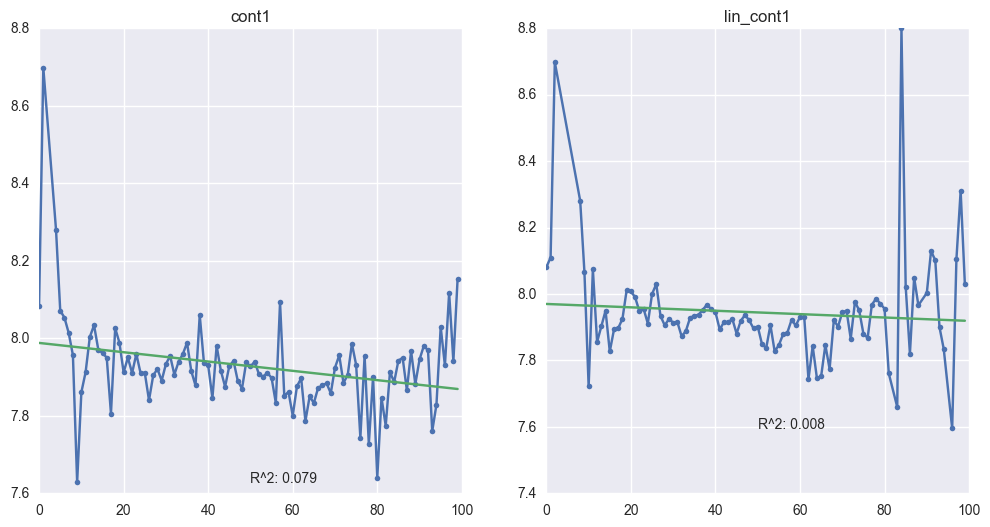

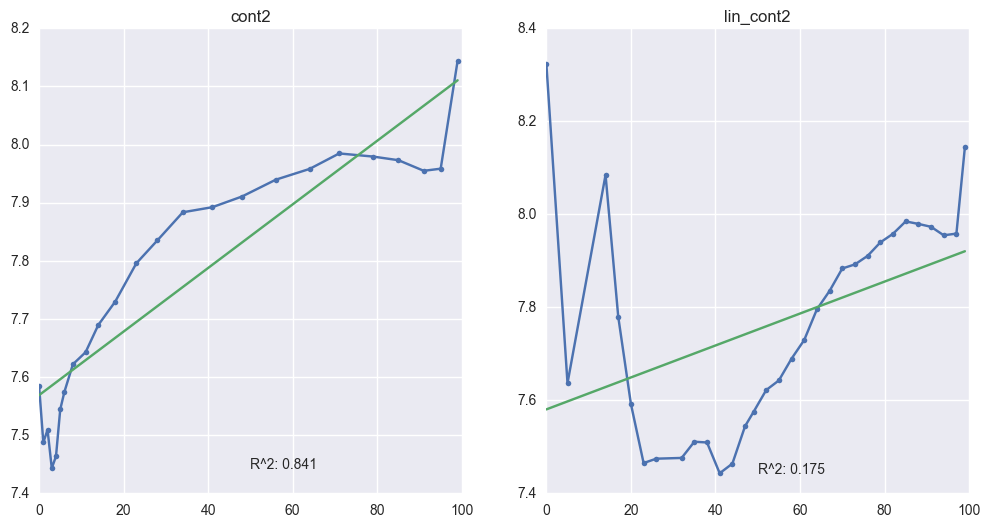

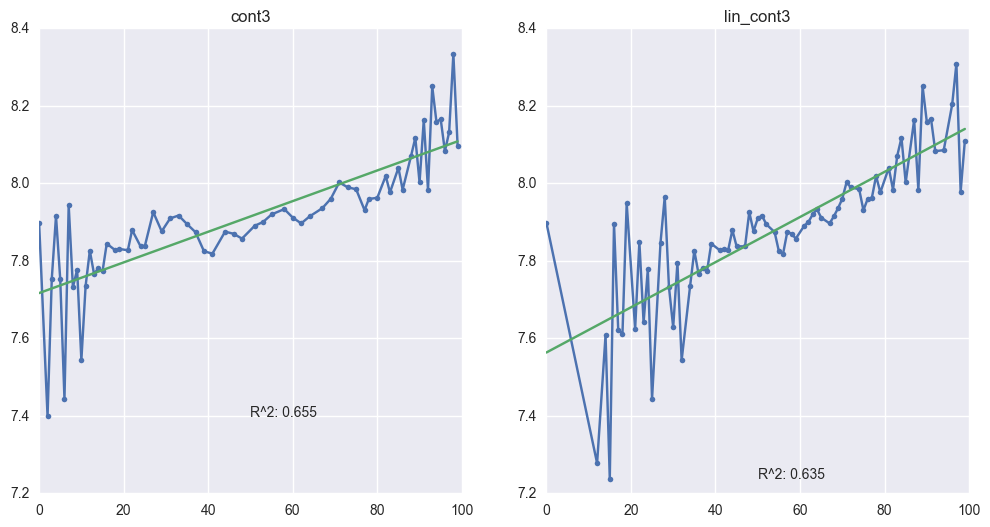

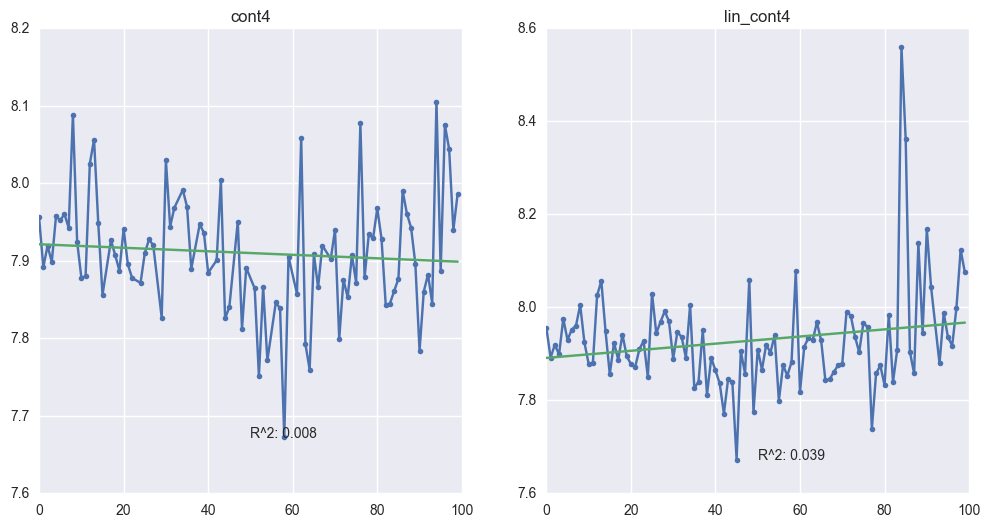

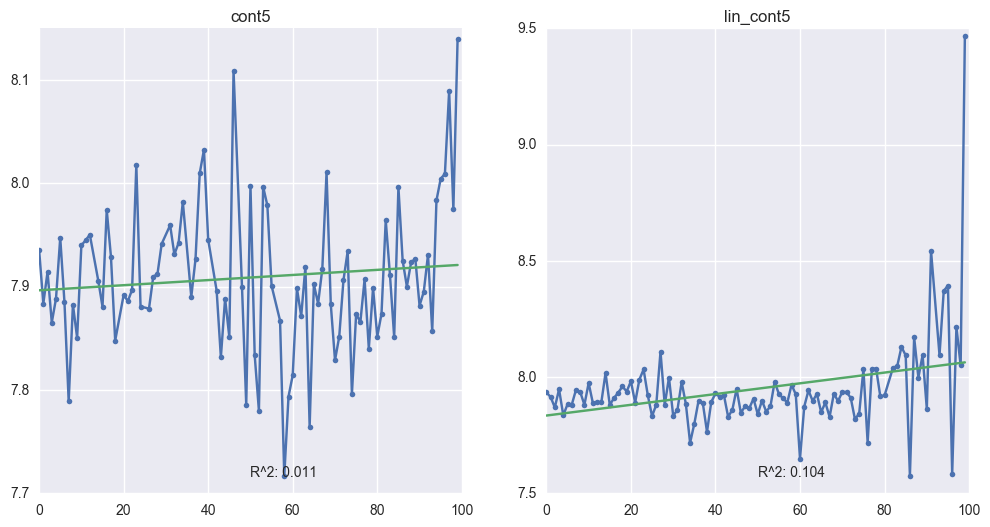

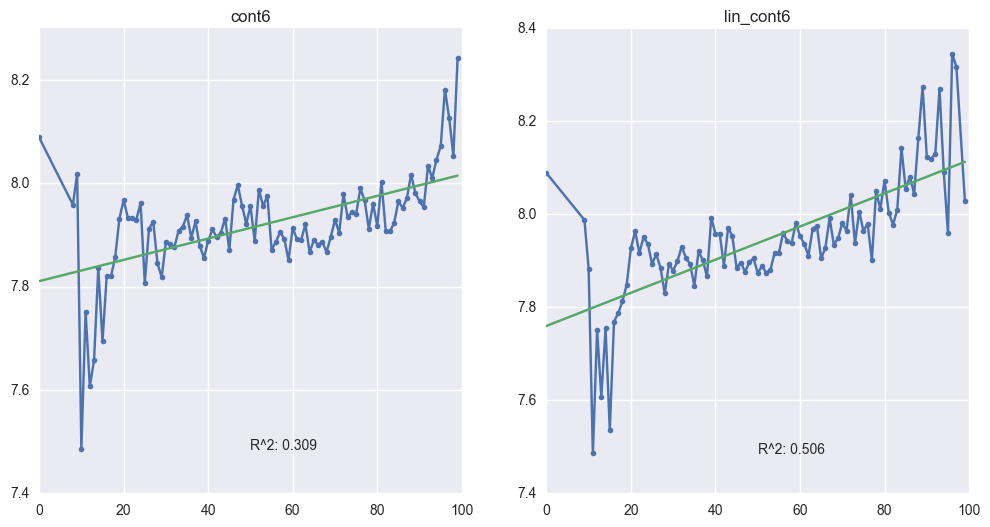

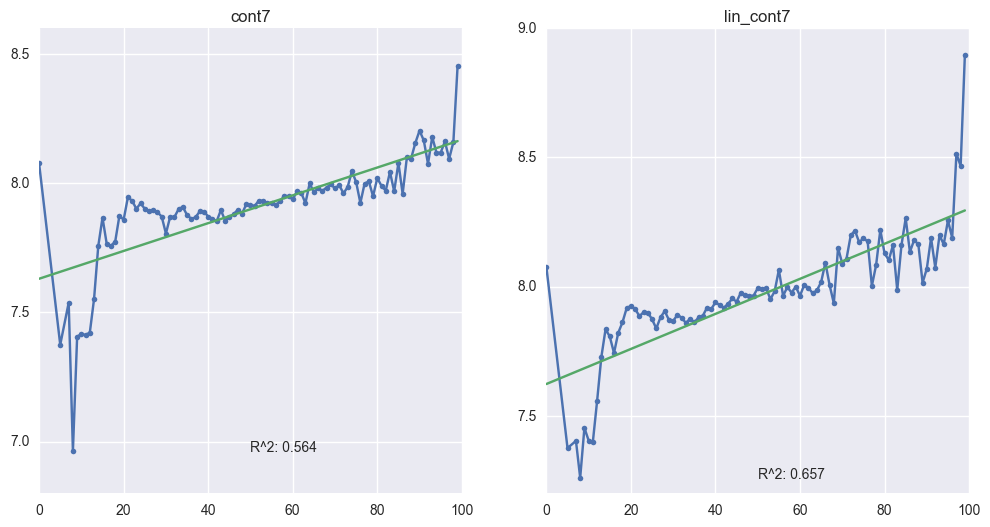

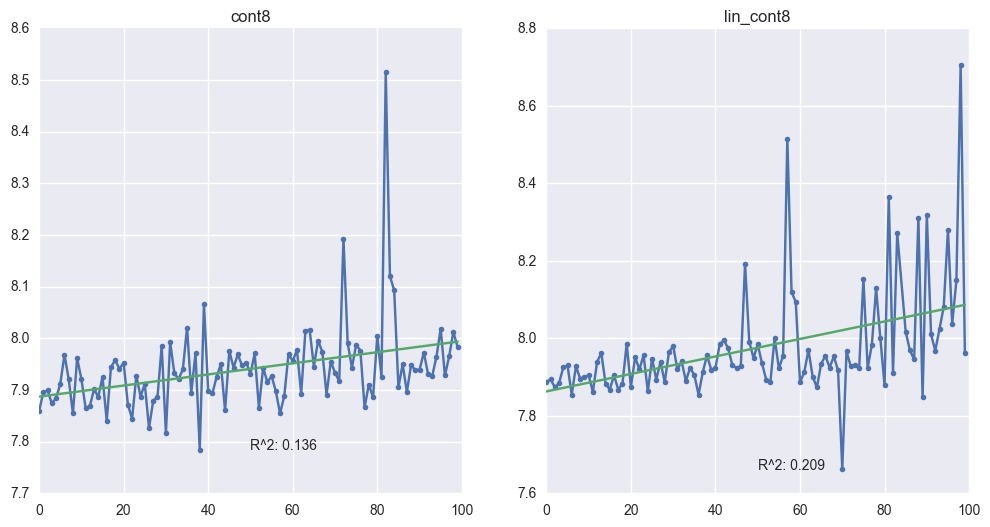

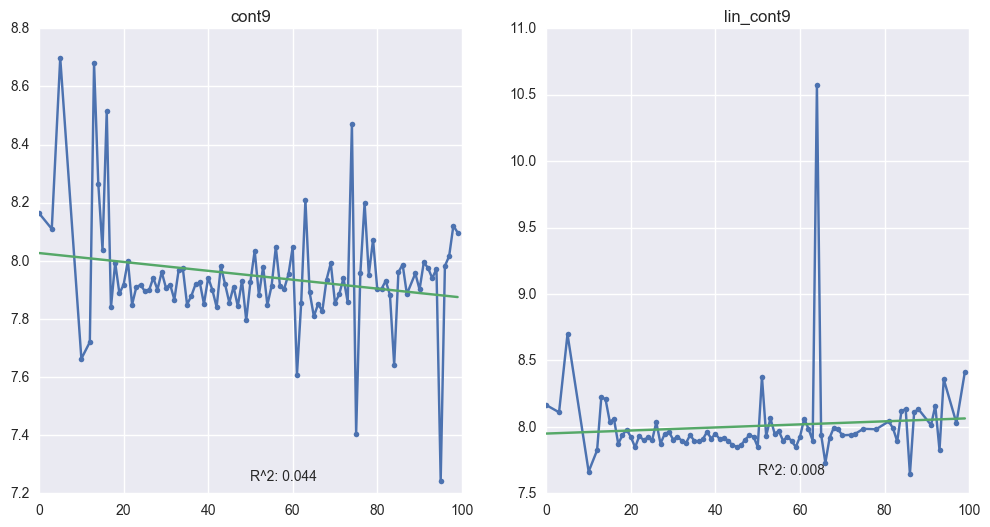

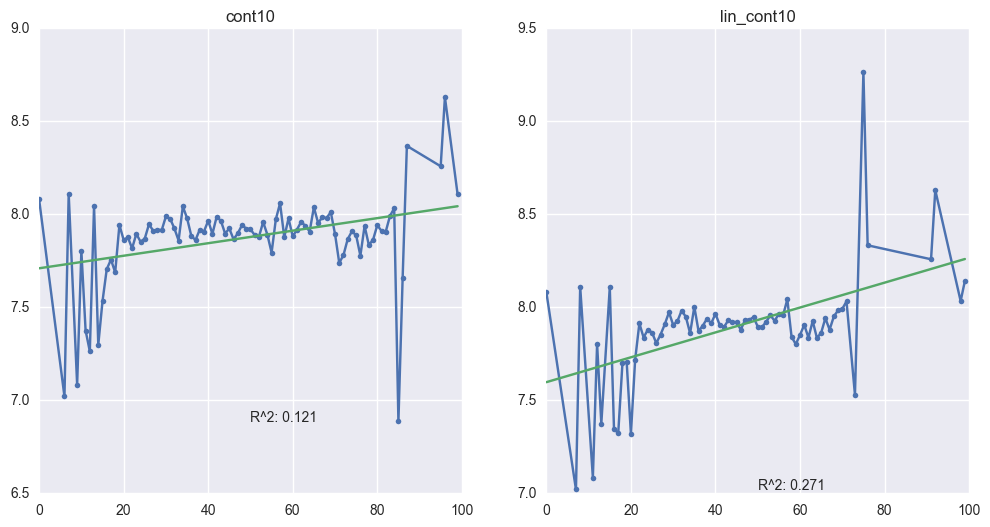

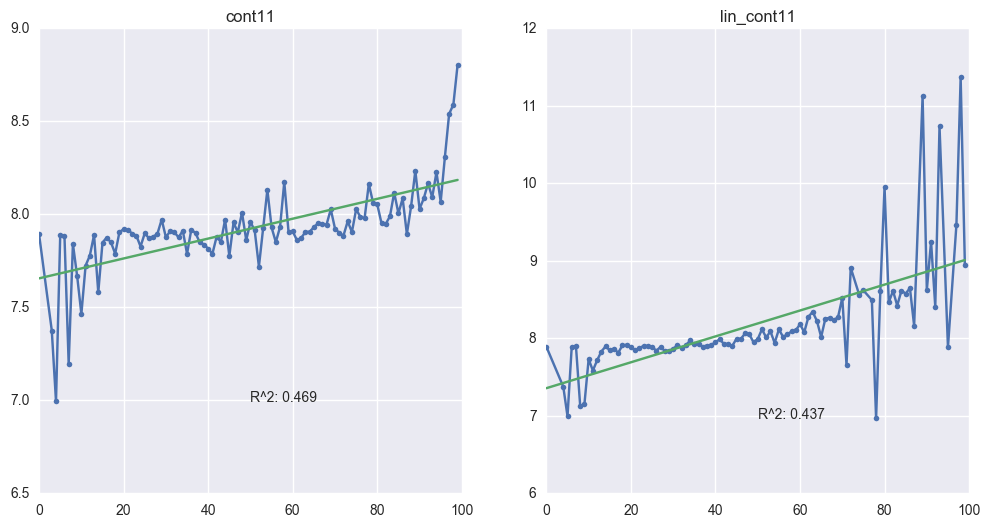

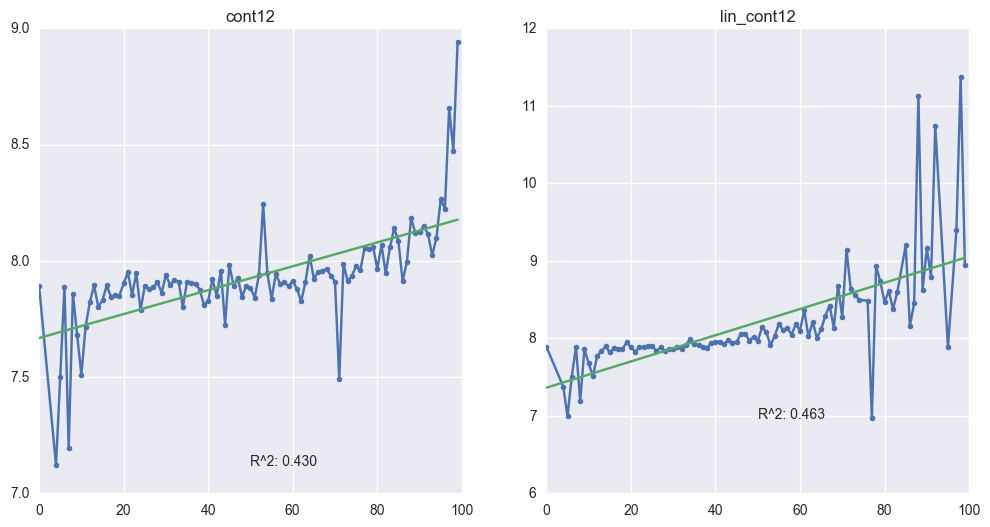

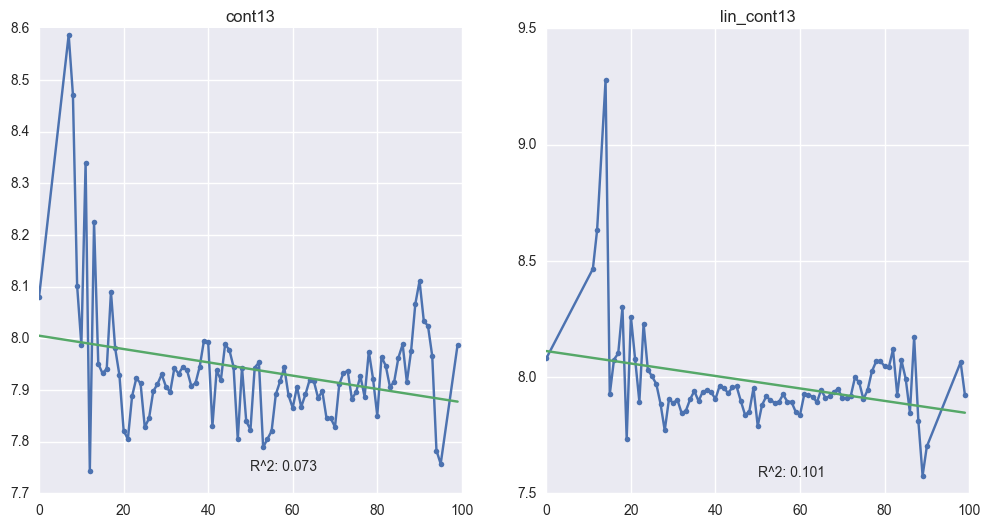

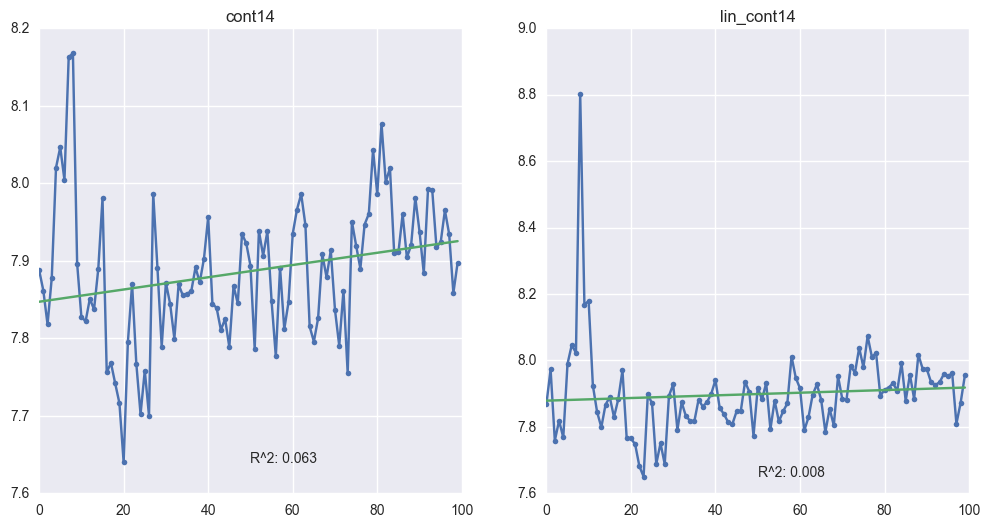

In [38]:
plot_cont_feature_bins(100, num_feats[0:14], y='logloss', lin=True)

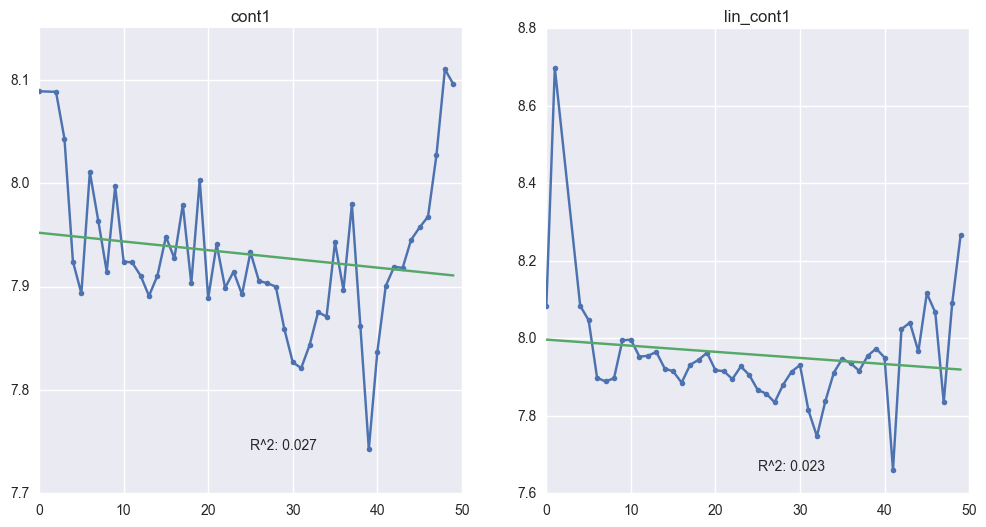

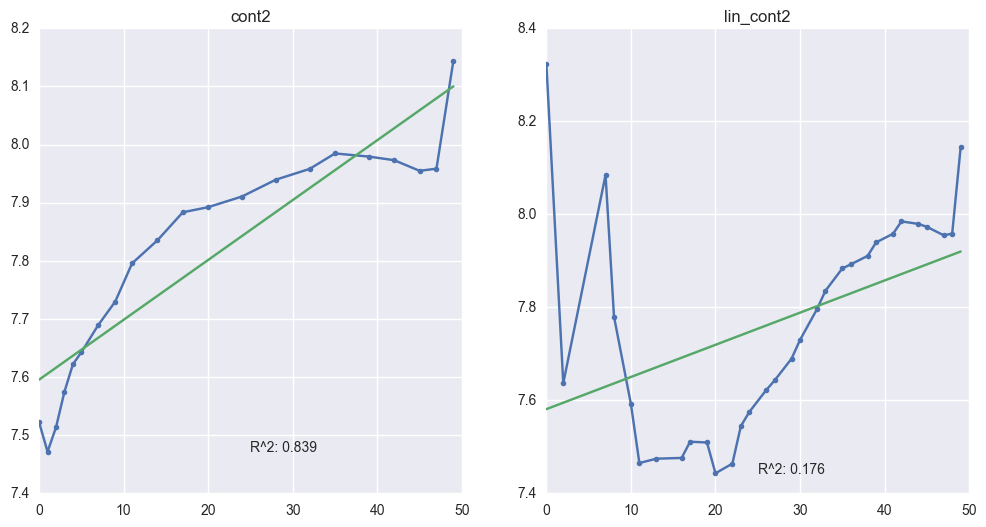

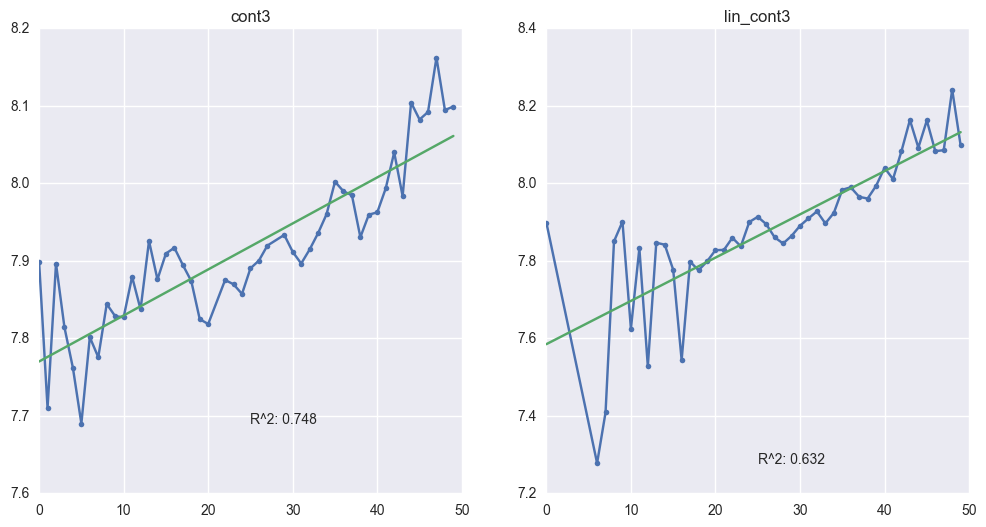

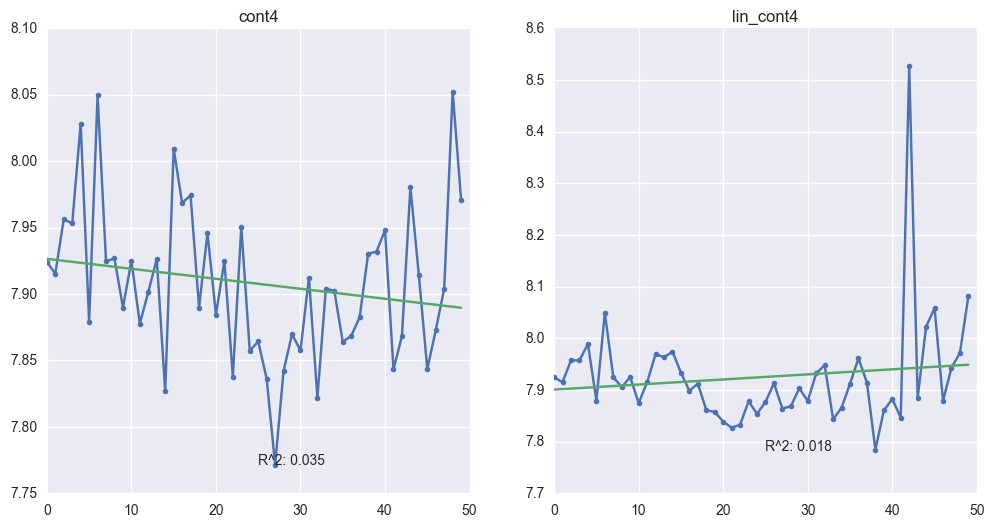

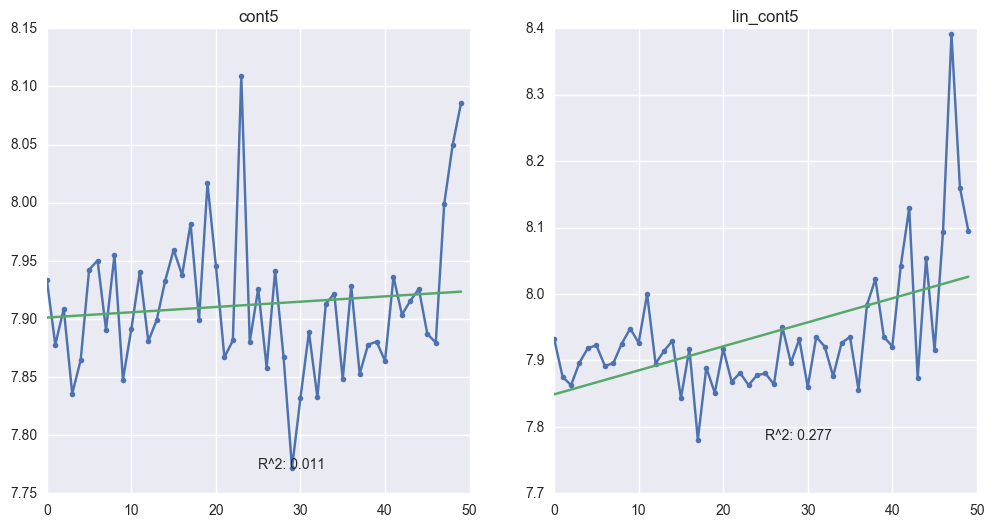

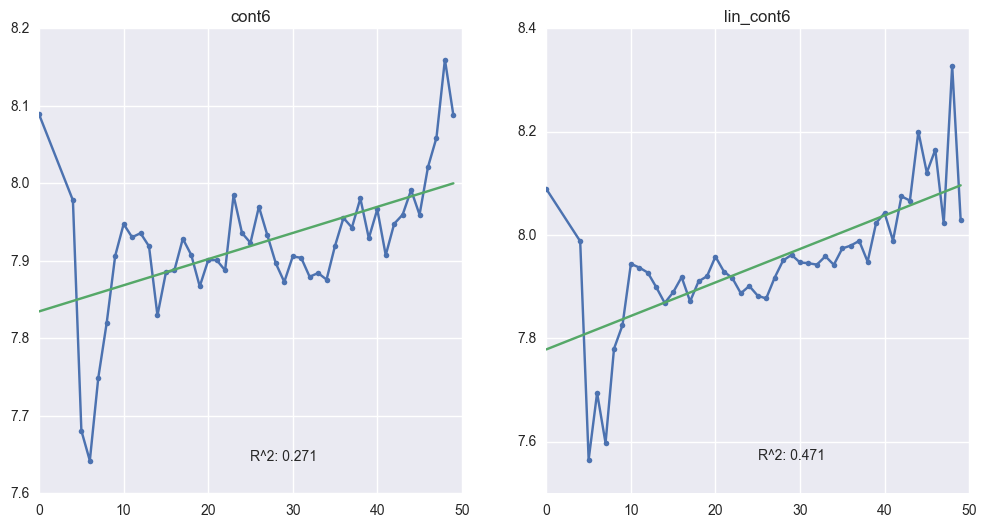

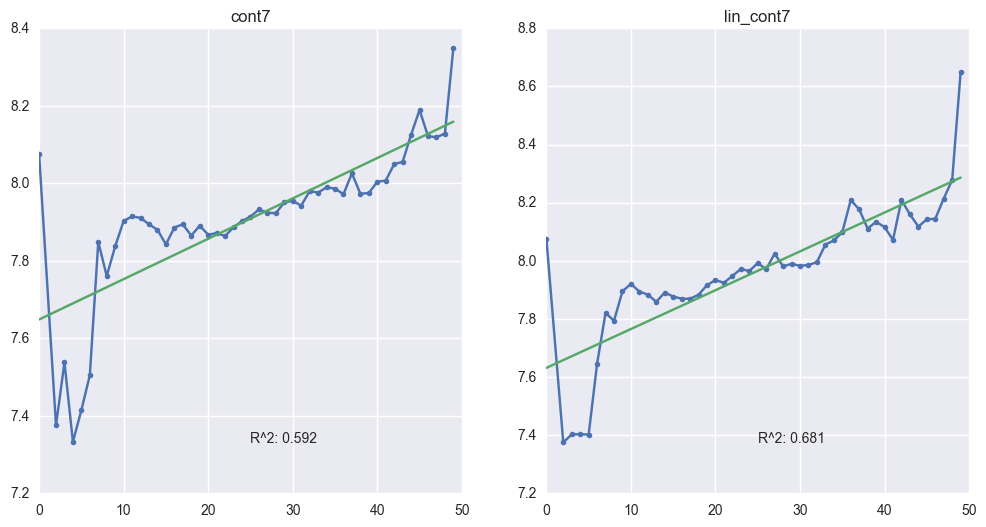

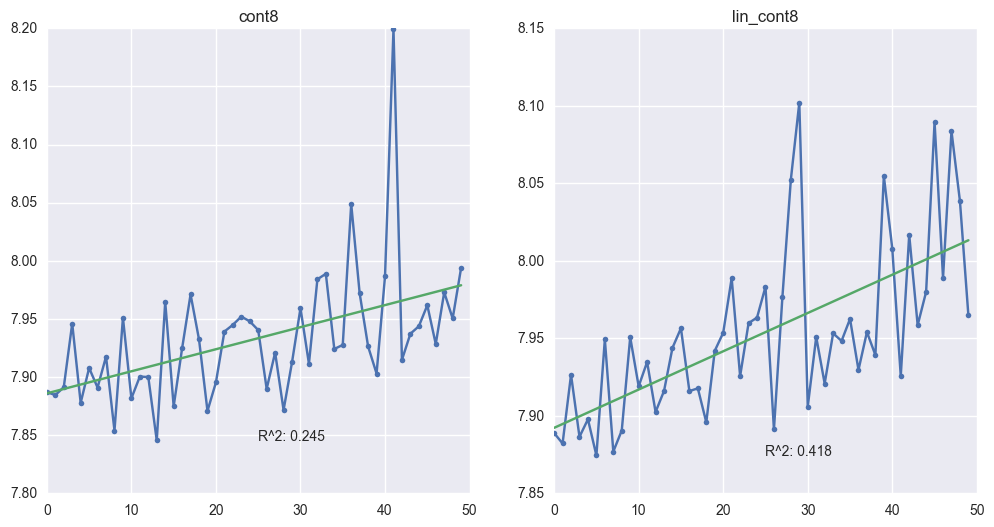

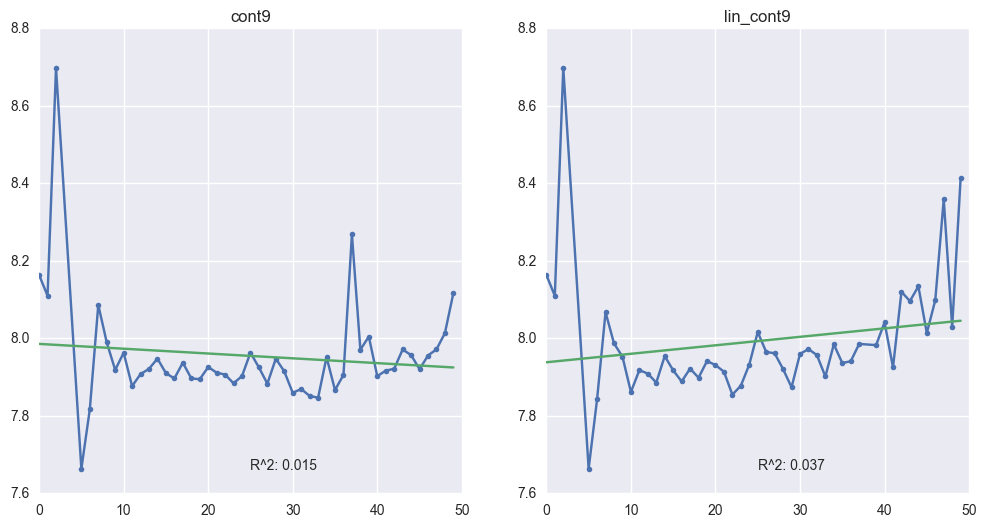

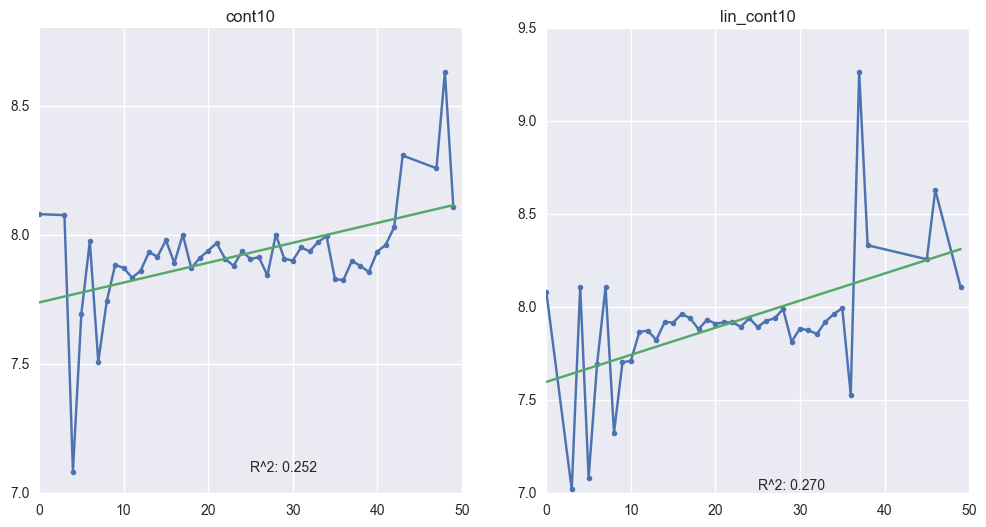

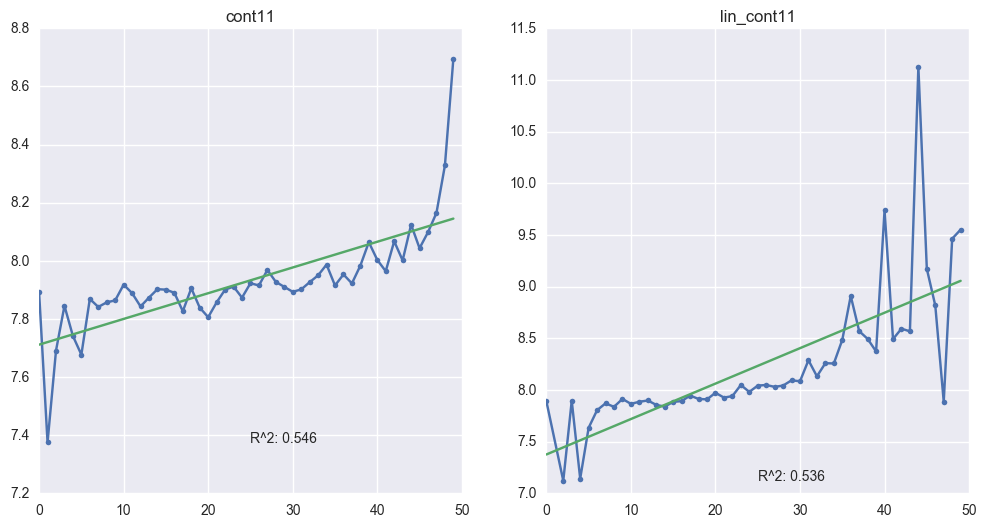

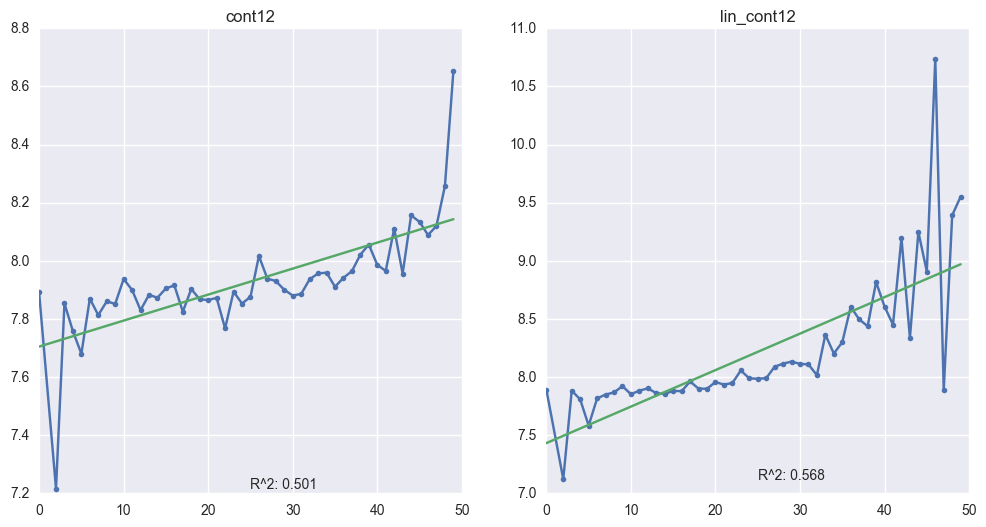

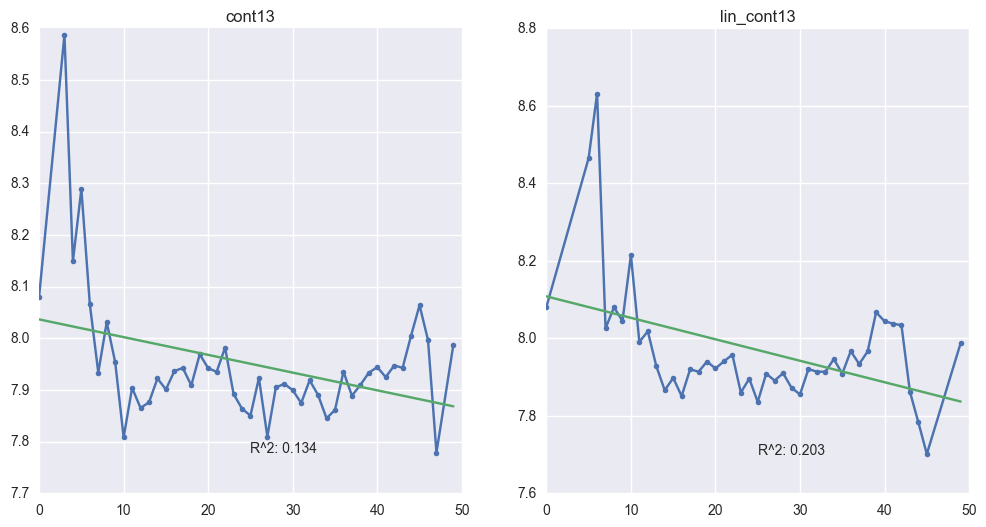

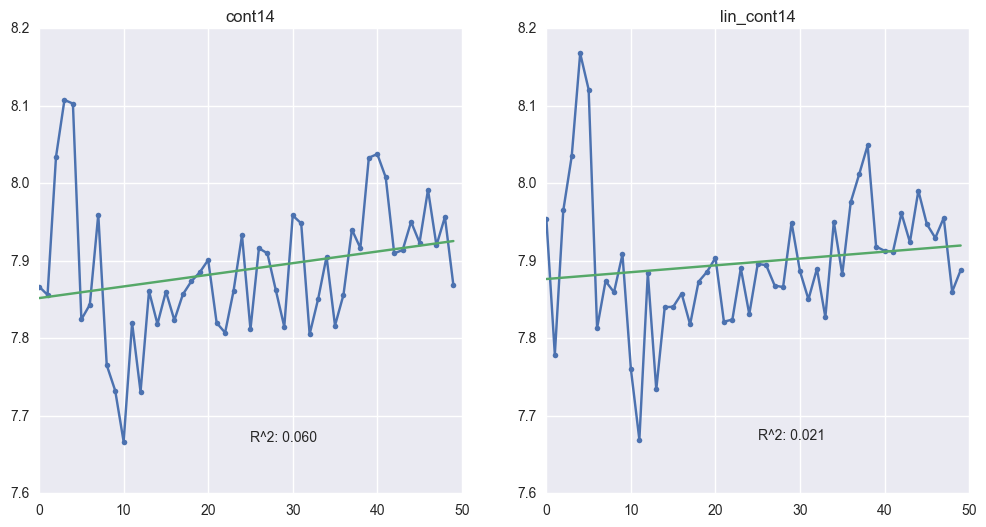

In [34]:
plot_cont_feature_bins(50, num_feats[0:14], y='logloss', lin=True)

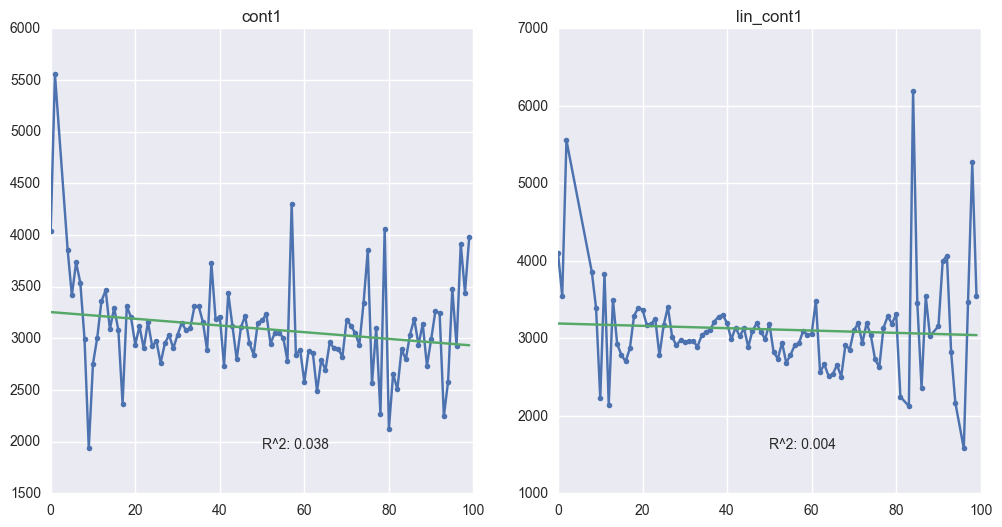

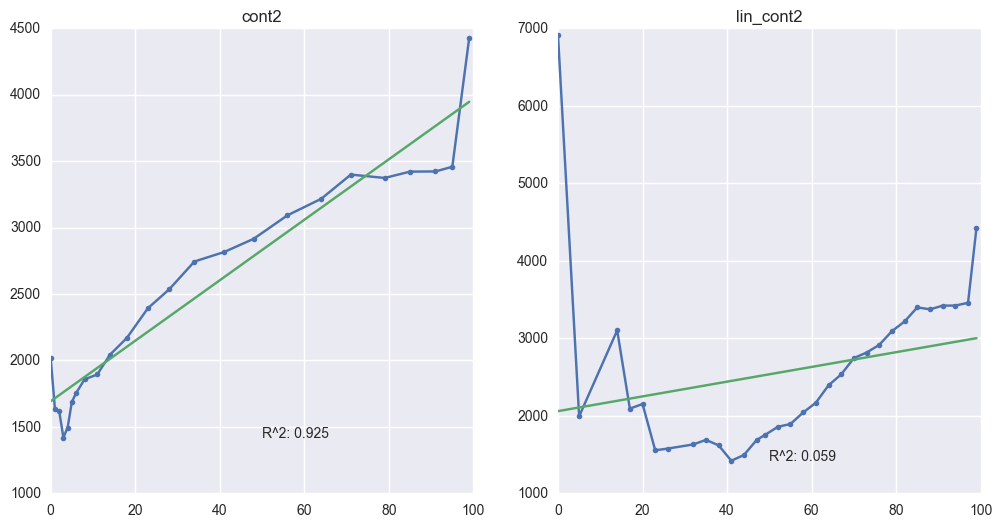

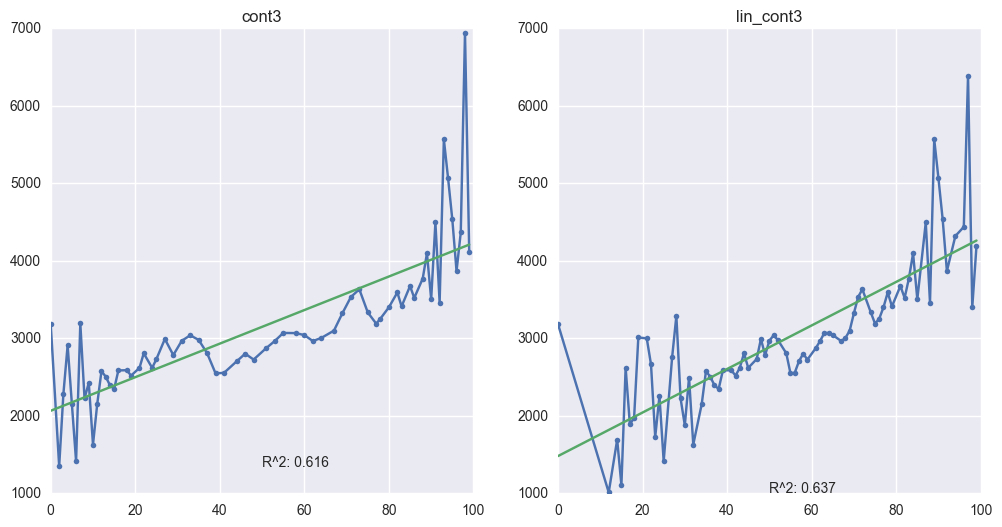

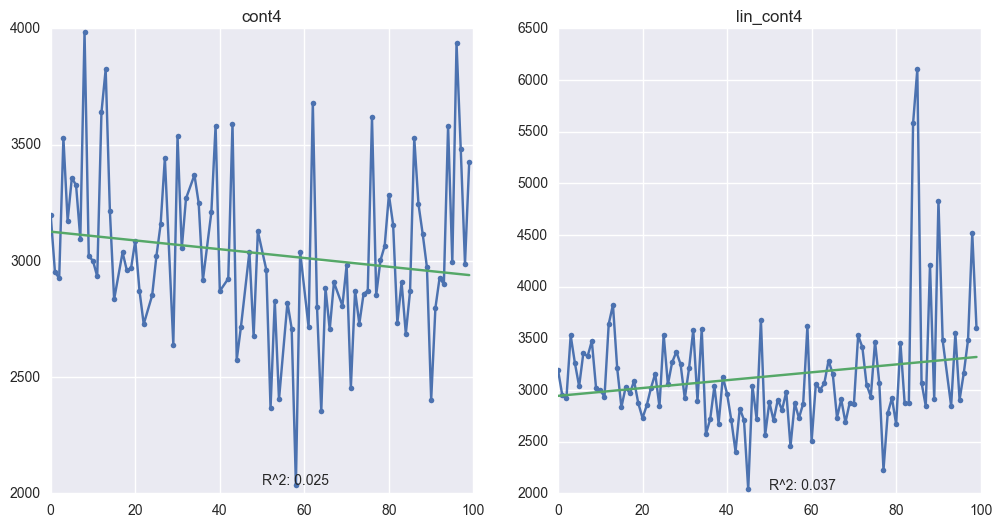

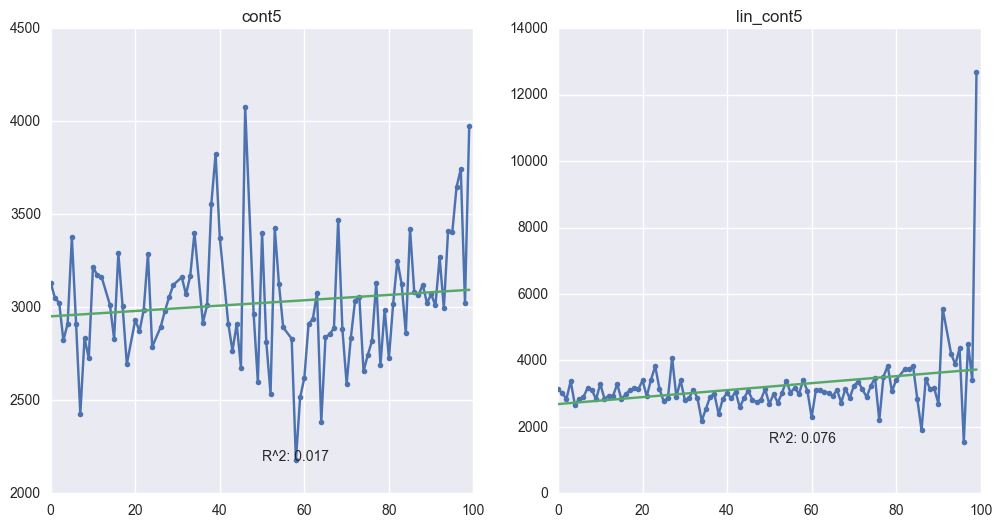

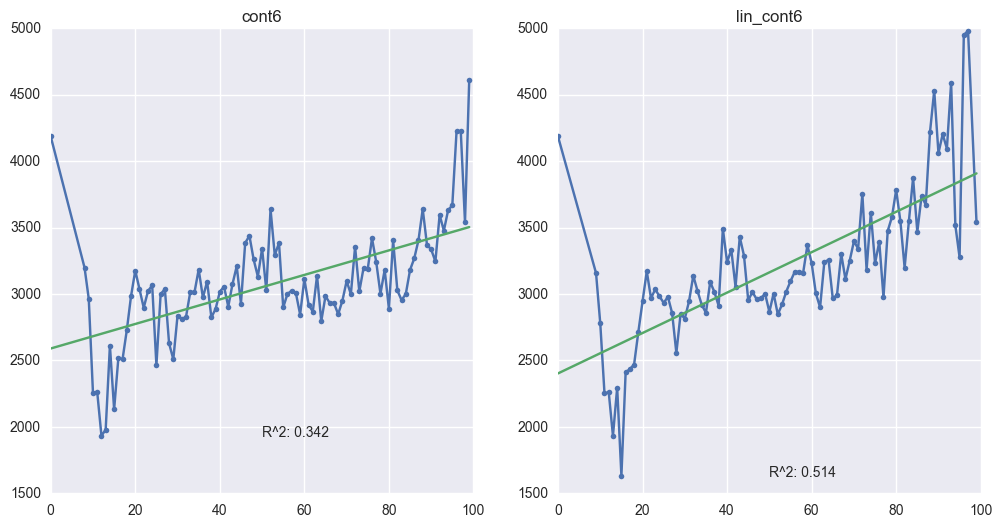

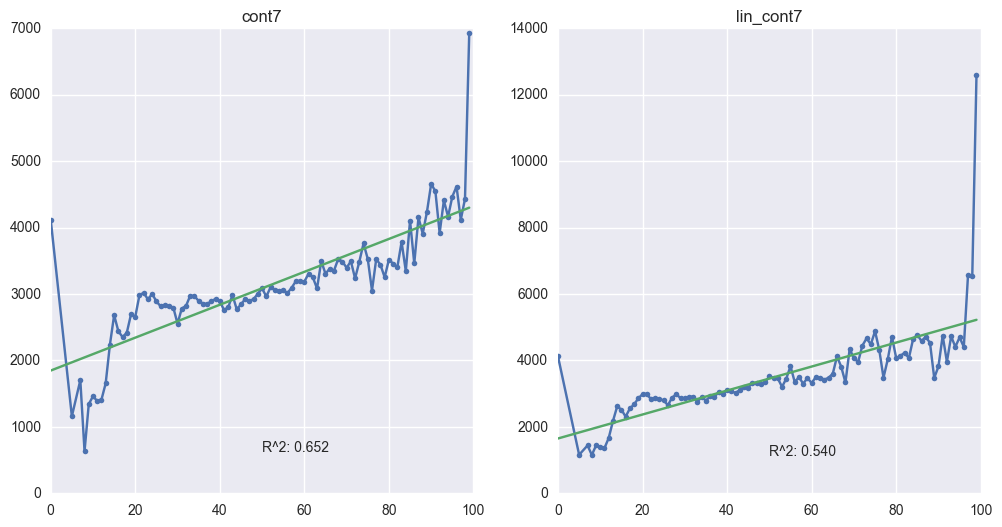

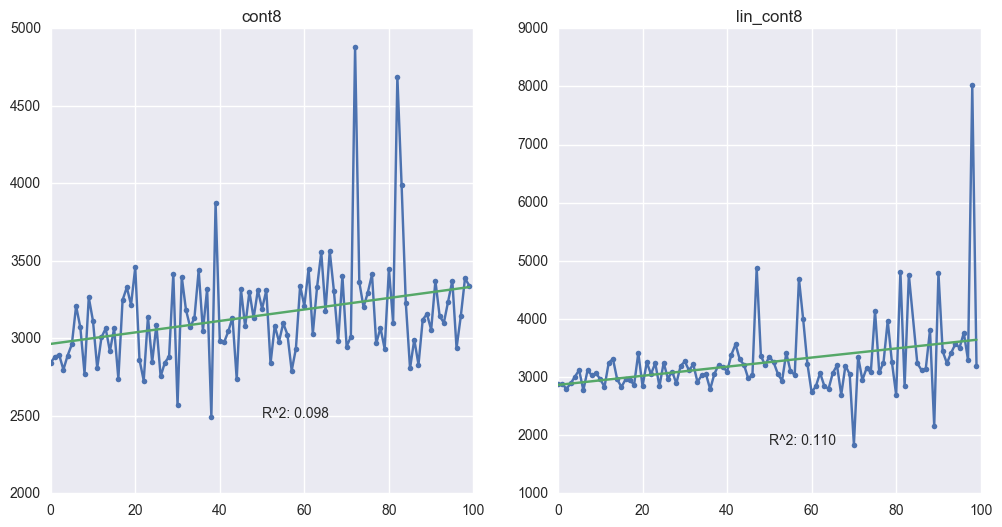

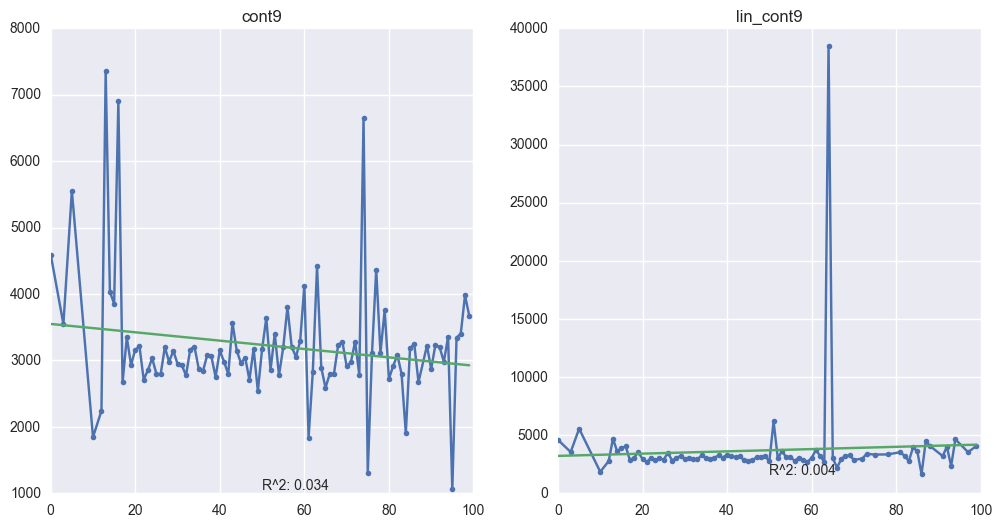

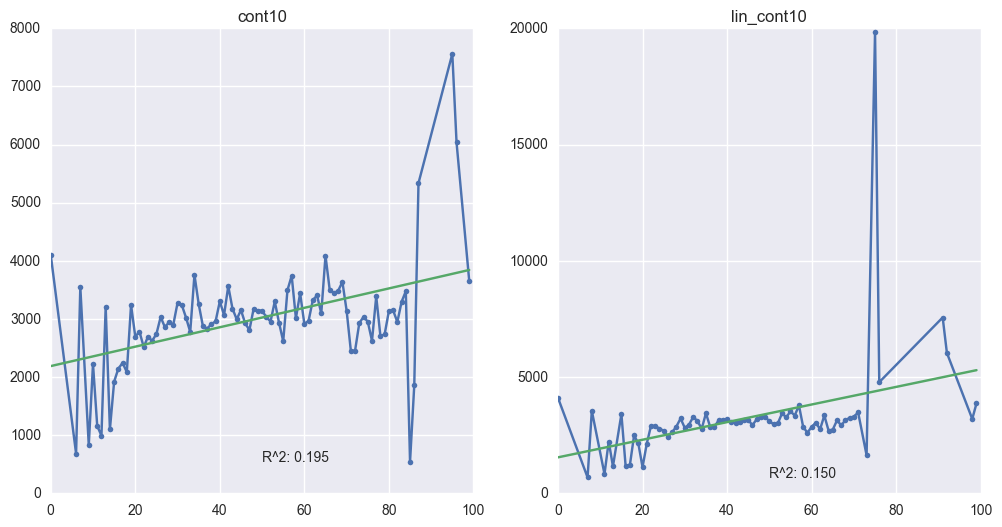

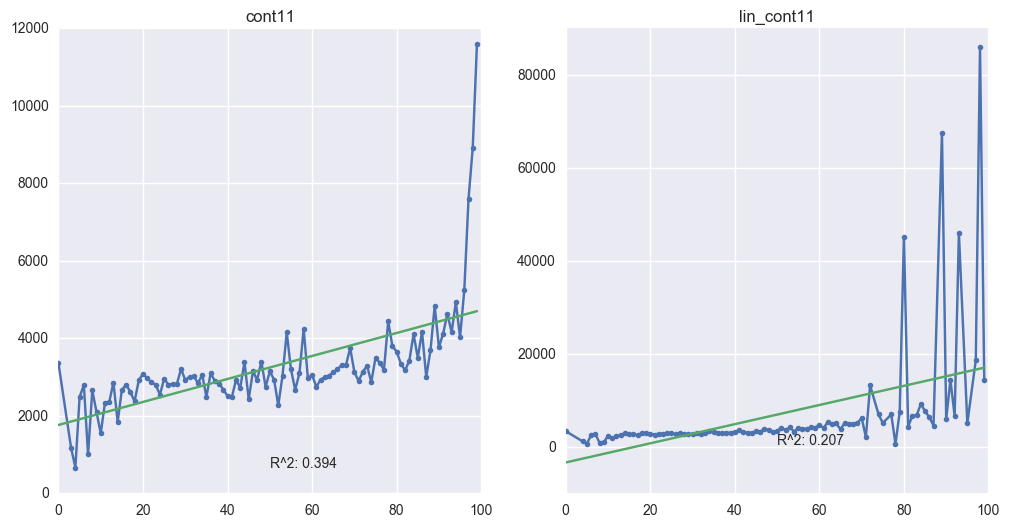

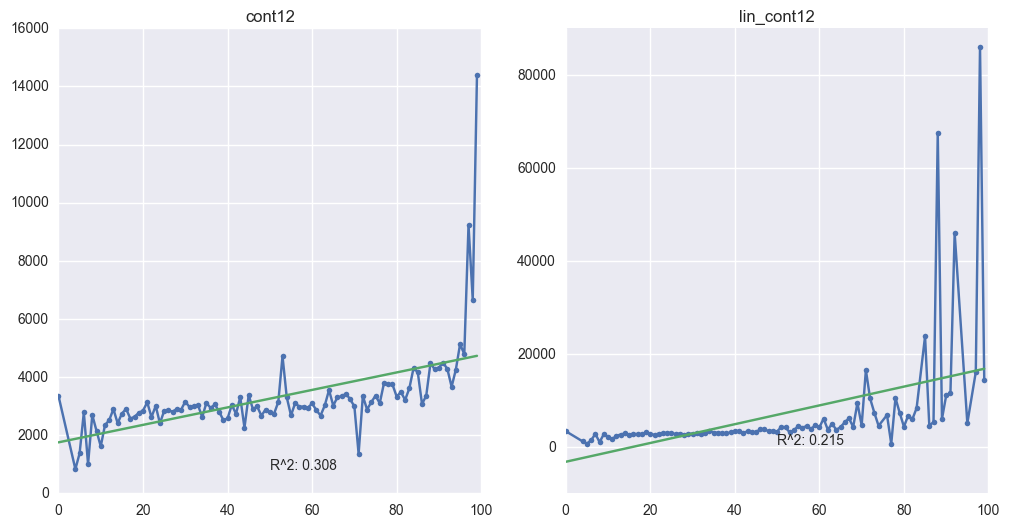

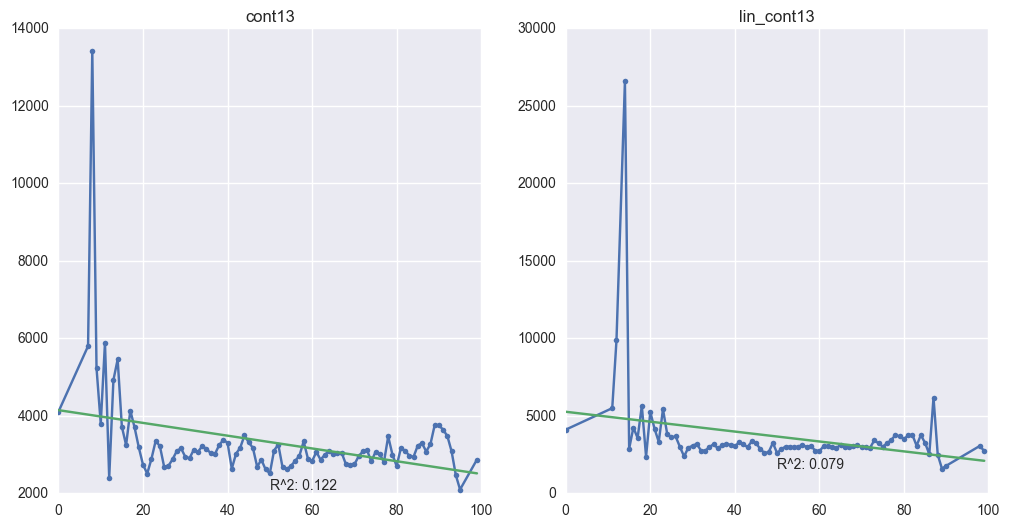

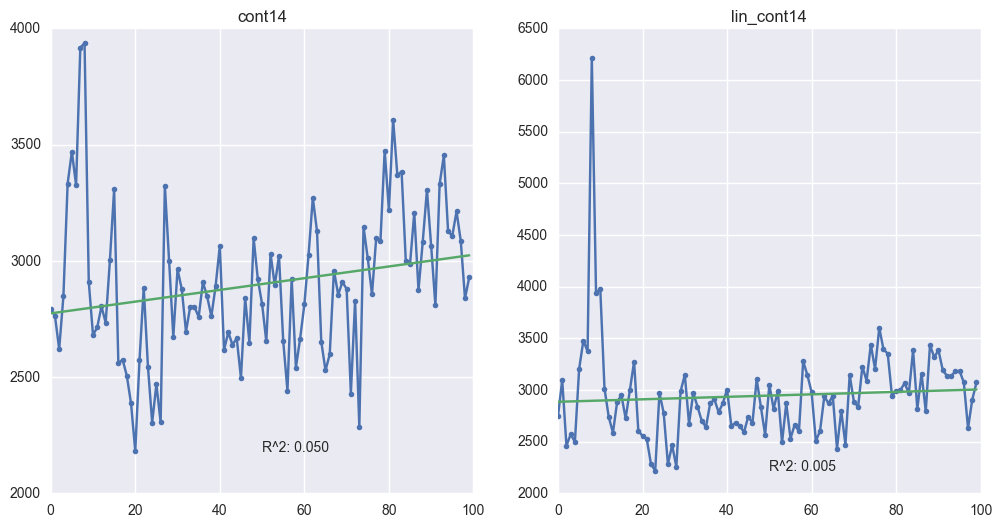

In [35]:
plot_cont_feature_bins(100, num_feats[0:14], y='loss', lin=True)

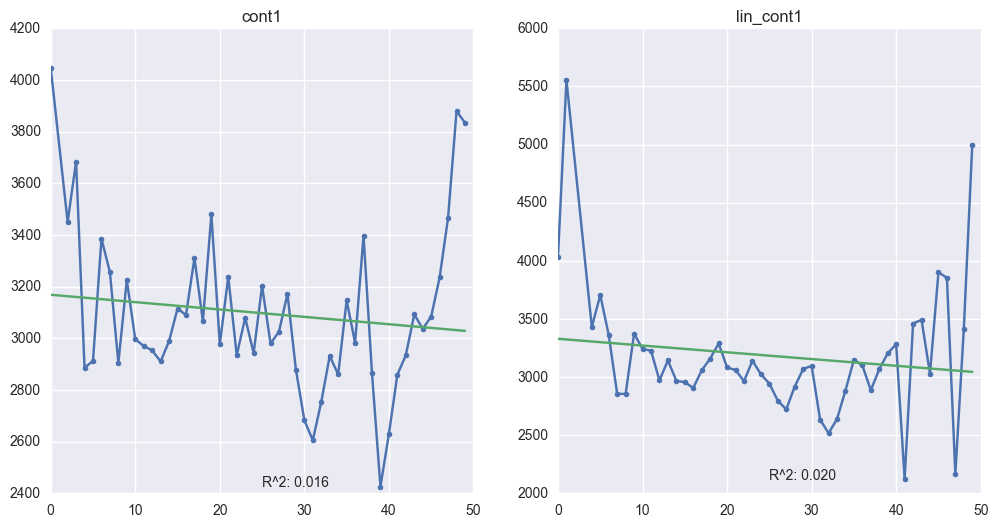

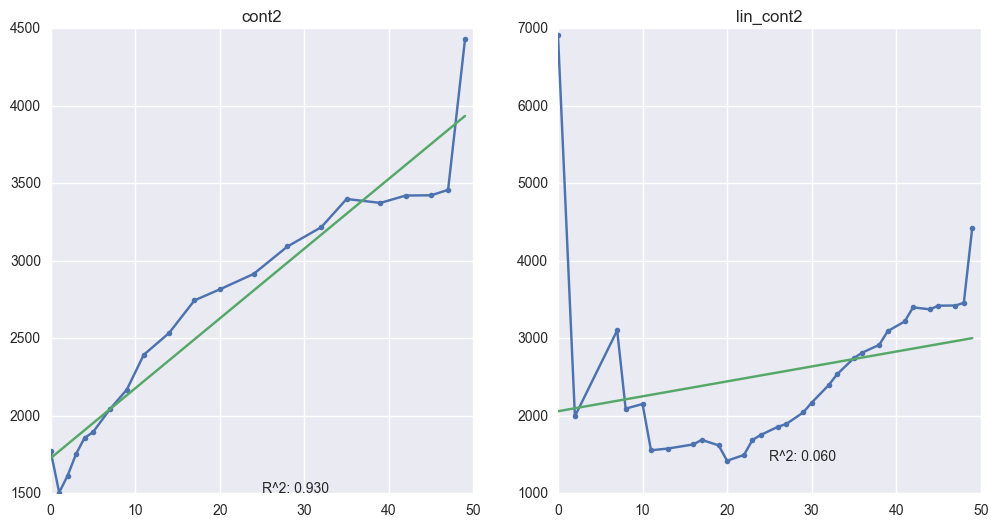

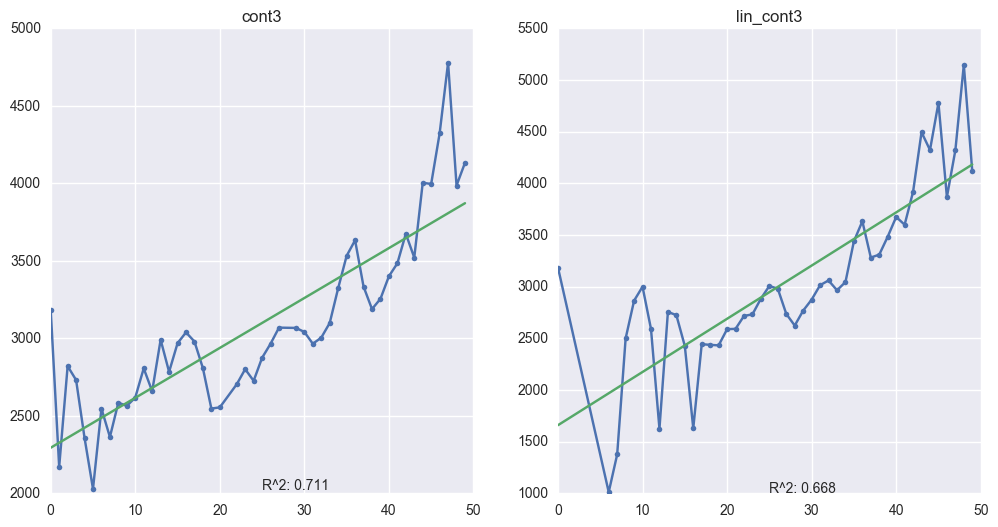

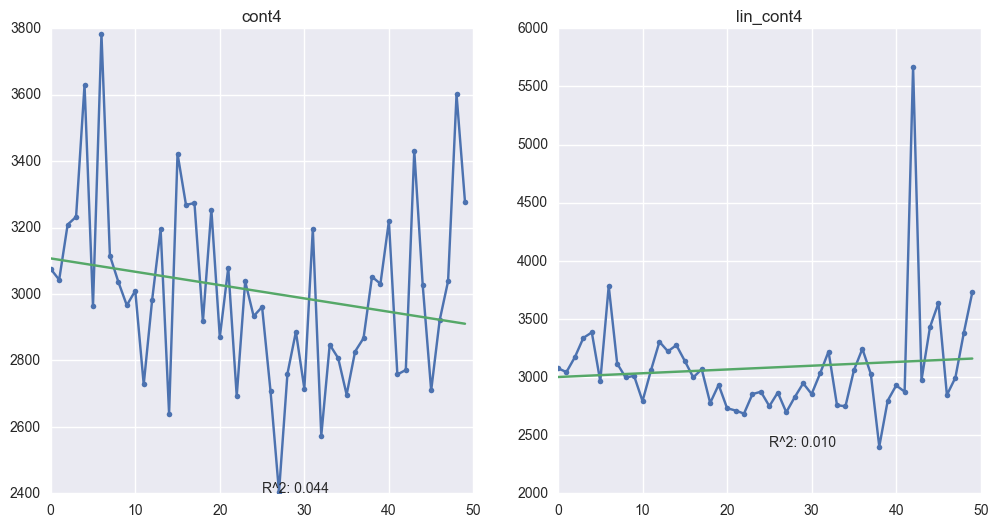

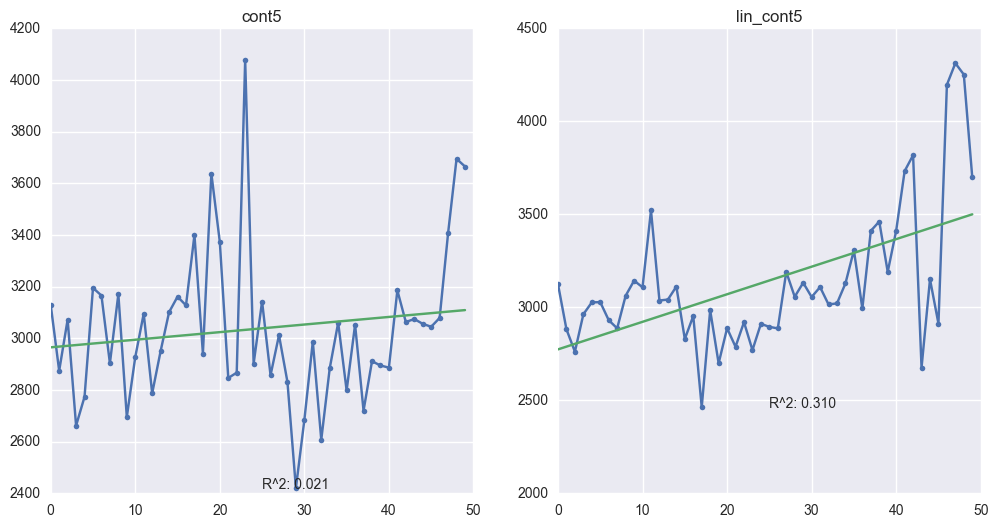

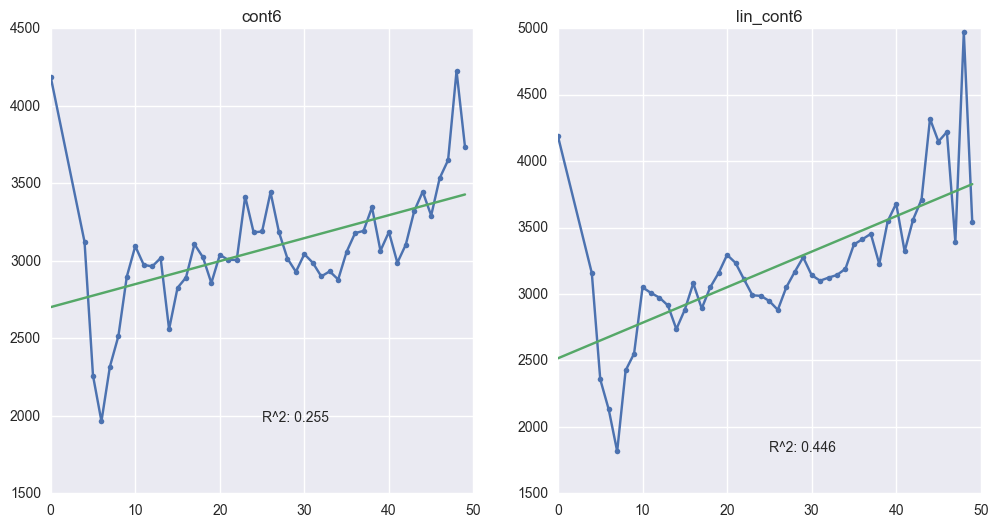

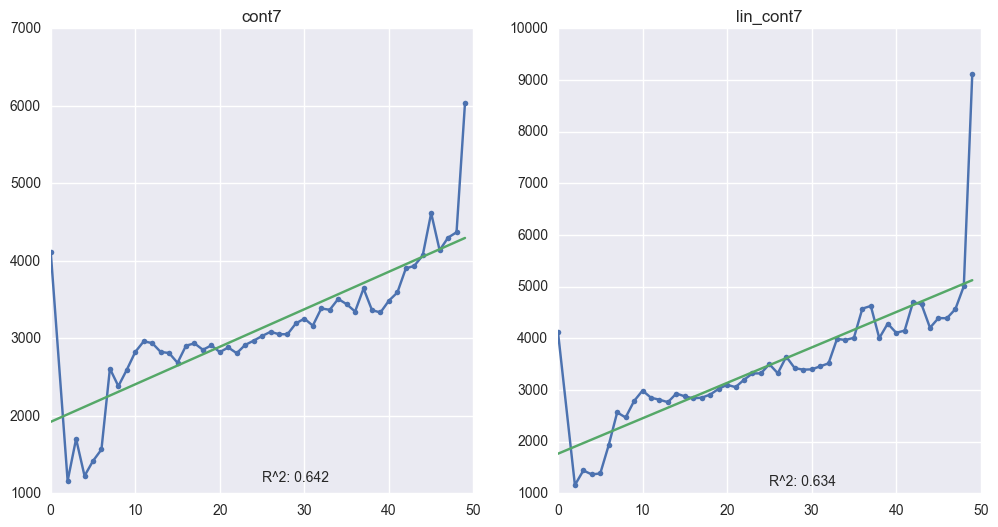

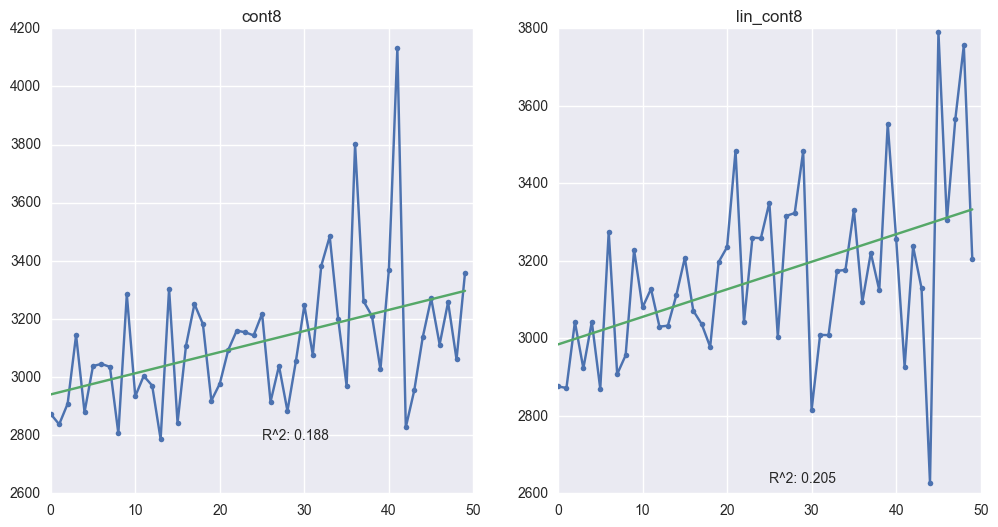

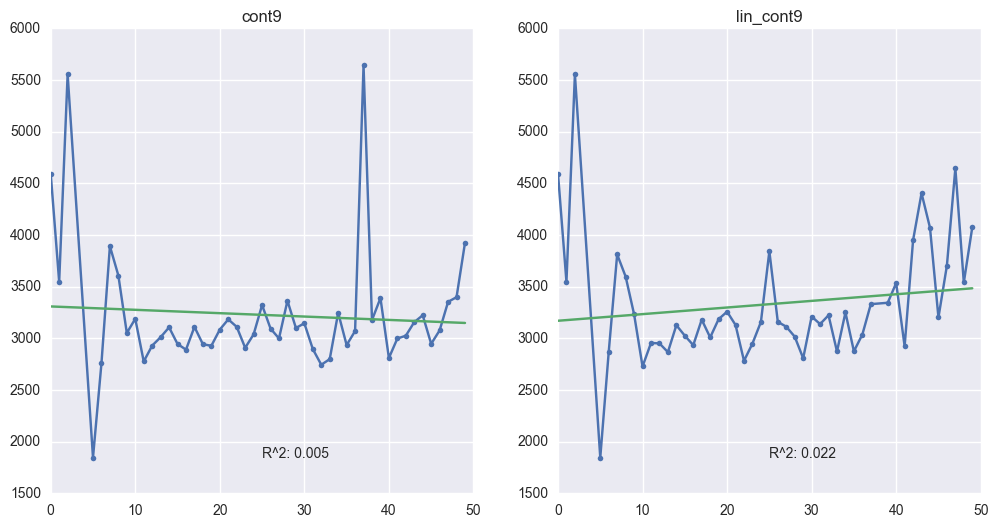

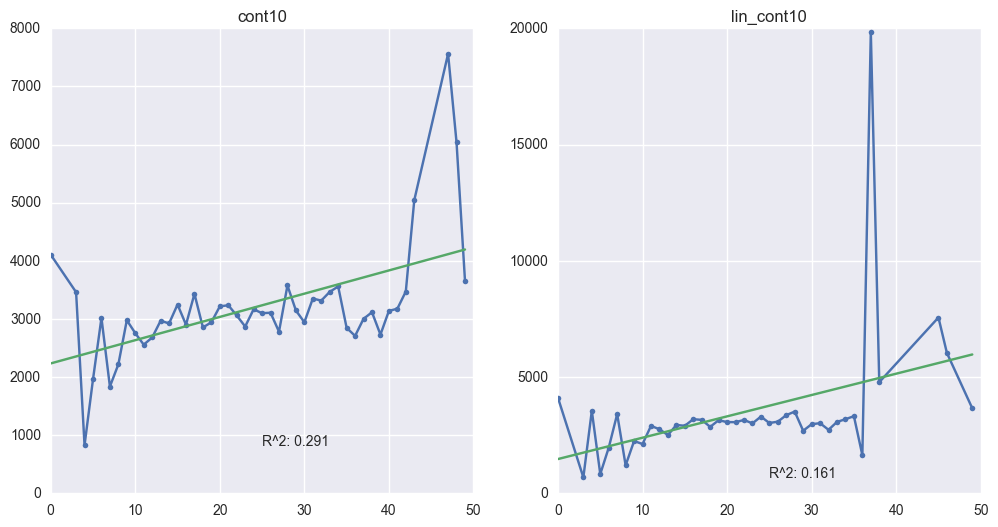

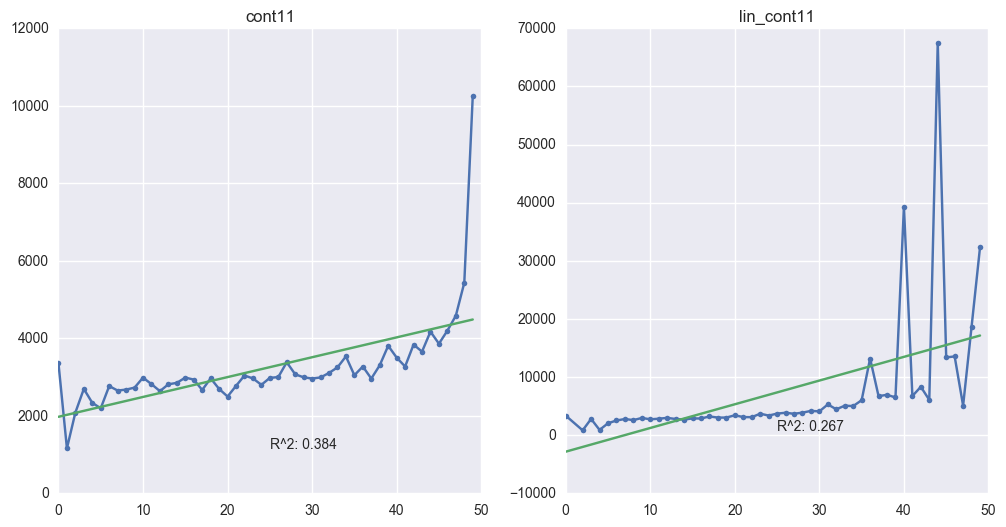

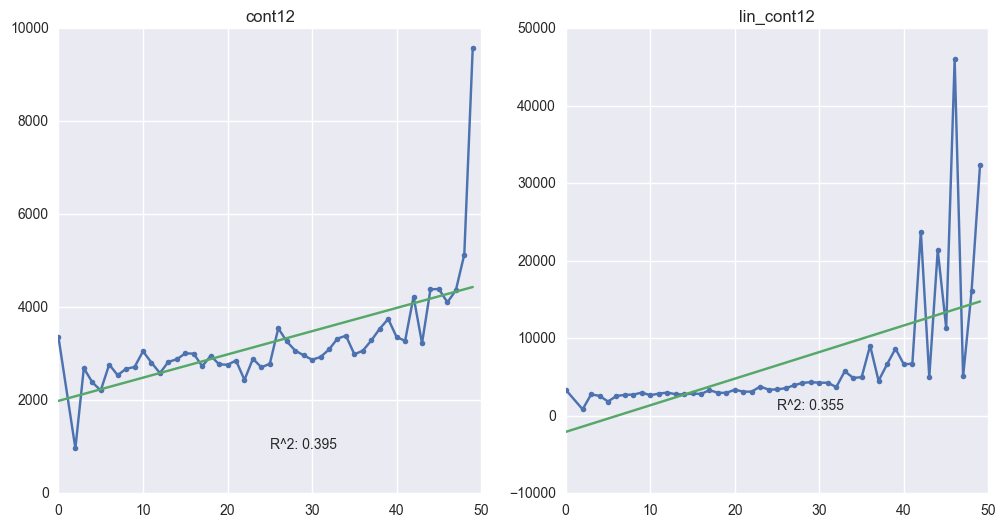

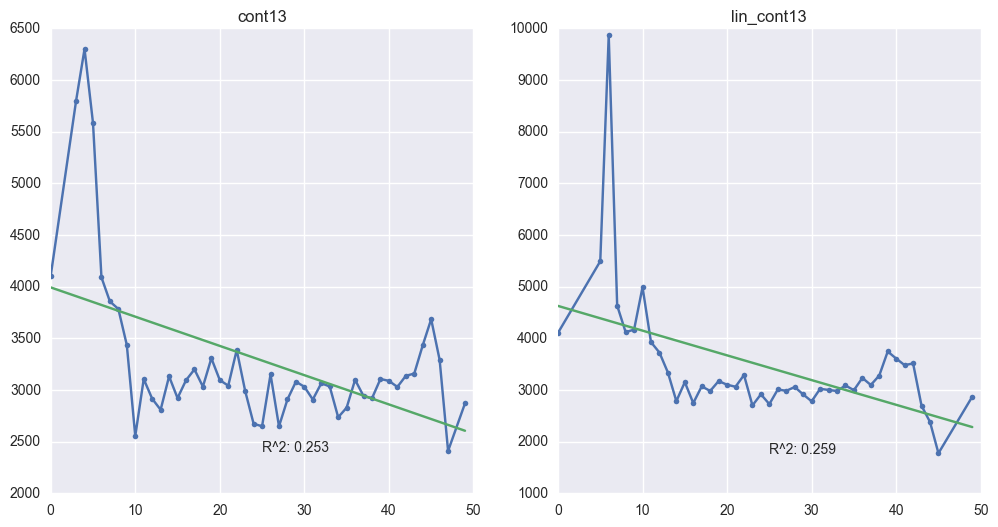

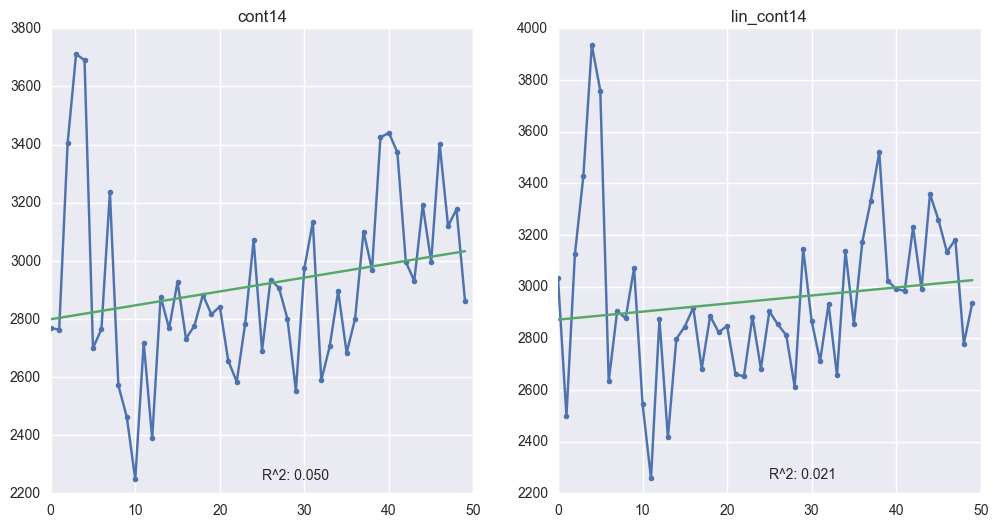

In [36]:
plot_cont_feature_bins(50, num_feats[0:14], y='loss', lin=True)

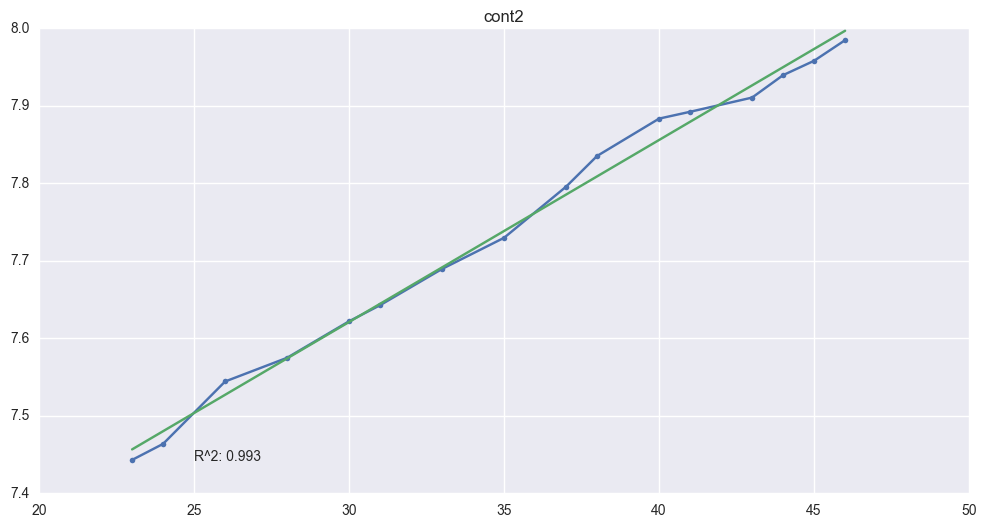

In [87]:
plot_cont_feature_bins(50, ['cont2'], 
                       y='logloss', 
                       lin=False,
                       transform=lambda x:np.power(x-.001, .13)-7.45,
                       outliers=[0,1,2,3,4,5,6,7,8,9,10,11,-1,-2, -3])

                          cont2   logloss  COUNT  INDEX
binned_cont2                                           
(0.0002875, 0.001494]  0.001149  7.636697      2      0
(0.001494, 0.001838]   0.001503  8.323420      3      1
(0.001838, 0.002183]   0.001966  8.084683      5      2
(0.002527, 0.002872]   0.002571  7.779771      7      4
(0.003217, 0.003561]   0.003362  7.471152     12      6
(0.00425, 0.004595]    0.004394  7.650087     25      9
(0.005629, 0.005973]   0.005742  7.465036     26     13
(0.007352, 0.007696]   0.007501  7.488682     35     18
(0.009764, 0.01011]    0.009792  7.464756     52     25
(0.01252, 0.01287]     0.012775  7.476012     69     33
(0.01631, 0.01666]     0.016651  7.510816     85     44
(0.02148, 0.02183]     0.021677  7.509259    133     59
(0.02803, 0.02837]     0.028177  7.443037    177     78
(0.0363, 0.03664]      0.036553  7.463753    365    102
(0.04698, 0.04733]     0.047297  7.544231    587    133
(0.06077, 0.06111]     0.061000  7.574824    774

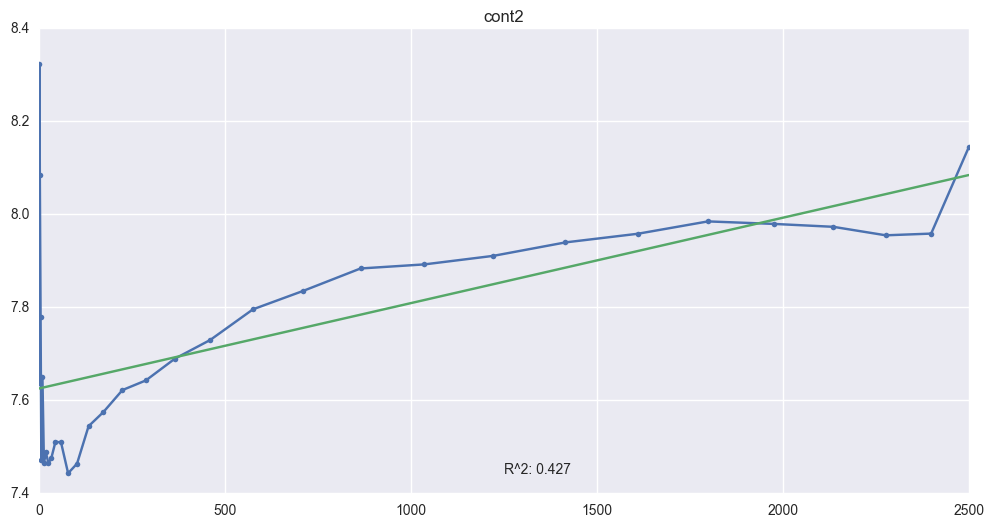

In [111]:
bins=2500
col='cont2'
f=lambda x:np.power(x-.001, .13)
df=train.loc[:,['cont2', 'logloss']]
# df['cont2'] = f(df['cont2'])
df['binned_'+col] = pd.cut(df[col], bins=bins)
binned = df.groupby(by='binned_'+col)
# binned = df.groupby(by=col)
binned_count = binned.count()
binned = binned.mean()
binned['COUNT'] = binned_count.iloc[:,0]
binned['INDEX'] = np.arange(binned.shape[0])
print binned.dropna()
plot_cont_feature_bins(bins, ['cont2'], 
                       y='logloss', 
                       lin=False,
                       transform=None)#lambda x:np.power(x-.001, .13)-7.45,
#                        outliers=[0,1,2,3,4,5,6,7,8,9,10,11,-1,-2, -3])

                       cont2   logloss  COUNT  INDEX
binned_cont2                                        
(0.02803, 0.02837]  0.028177  7.443037    177     78
(0.0363, 0.03664]   0.036553  7.463753    365    102
(0.04698, 0.04733]  0.047297  7.544231    587    133
(0.06077, 0.06111]  0.061000  7.574824    774    173
(0.07834, 0.07868]  0.078346  7.621943   1388    224
(0.1, 0.1004]       0.100099  7.642690   2025    287
(0.1269, 0.1273]    0.127059  7.689492   3257    365
(0.1597, 0.16]      0.159990  7.729675   5313    460
(0.1993, 0.1996]    0.199504  7.795618   6917    575
(0.2458, 0.2462]    0.245921  7.835247   9423    710
(0.2989, 0.2992]    0.299102  7.883436  11578    864
(0.3582, 0.3585]    0.358319  7.892244  14370   1036
(0.4219, 0.4223]    0.422197  7.910577  16945   1221
(0.4888, 0.4891]    0.488789  7.939520  18725   1415
(0.5556, 0.556]     0.555782  7.958061  20975   1609
(0.6207, 0.6211]    0.620805  7.984676  20190   1798
(0.6817, 0.6821]    0.681761  7.979290  14721 

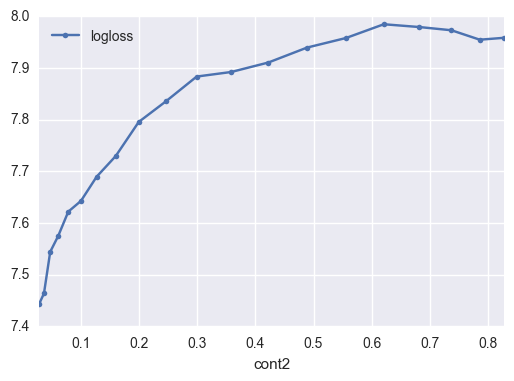

In [120]:
clean_binned=binned.dropna().iloc[12:-1,:]
print clean_binned
clean_binned.plot('cont2', 'logloss', marker='o', ms=4)
plt.show()

[-1.42779714  1.74261241  7.46262284]
                       cont2   logloss  COUNT  INDEX     y_hat     resid
binned_cont2                                                            
(0.02803, 0.02837]  0.028177  7.443037    177     78  7.510591 -0.067554
(0.0363, 0.03664]   0.036553  7.463753    365    102  7.524413 -0.060660
(0.04698, 0.04733]  0.047297  7.544231    587    133  7.541849  0.002382
(0.06077, 0.06111]  0.061000  7.574824    774    173  7.563609  0.011215
(0.07834, 0.07868]  0.078346  7.621943   1388    224  7.590386  0.031557
(0.1, 0.1004]       0.100099  7.642690   2025    287  7.622750  0.019940
(0.1269, 0.1273]    0.127059  7.689492   3257    365  7.660987  0.028505
(0.1597, 0.16]      0.159990  7.729675   5313    460  7.704876  0.024799
(0.1993, 0.1996]    0.199504  7.795618   6917    575  7.753452  0.042166
(0.2458, 0.2462]    0.245921  7.835247   9423    710  7.804819  0.030428
(0.2989, 0.2992]    0.299102  7.883436  11578    864  7.856108  0.027328
(0.3582, 0.35

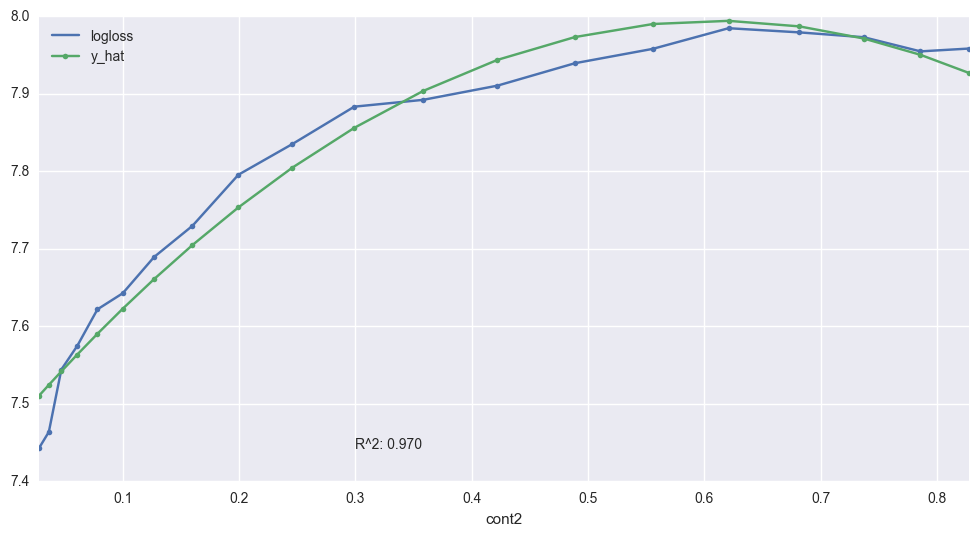

In [138]:
coeffs = np.polyfit(clean_binned.cont2, clean_binned.logloss, 2)
print coeffs
poly = np.poly1d(coeffs)
clean_binned['y_hat'] = poly(clean_binned.cont2)
clean_binned['resid'] = clean_binned.logloss - clean_binned.y_hat
print clean_binned
r2 = r2_score(clean_binned.logloss, clean_binned.y_hat)

fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111)
clean_binned.plot('cont2','logloss', marker='o', ms=4, ax=ax)
clean_binned.plot('cont2', 'y_hat', marker='o', ms=4, ax=ax)
ax.text(.3, clean_binned['logloss'].min(), "R^2: {:.3f}".format(r2))
plt.show()

                       cont2   logloss  COUNT  INDEX     y_hat     resid
binned_cont2                                                            
(0.02803, 0.02837]  0.028177  7.443037    177     78  7.504690 -0.061653
(0.0363, 0.03664]   0.036553  7.463753    365    102  7.521006 -0.057253
(0.04698, 0.04733]  0.047297  7.544231    587    133  7.541669  0.002563
(0.06077, 0.06111]  0.061000  7.574824    774    173  7.567542  0.007282
(0.07834, 0.07868]  0.078346  7.621943   1388    224  7.599429  0.022514
(0.1, 0.1004]       0.100099  7.642690   2025    287  7.637870  0.004821
(0.1269, 0.1273]    0.127059  7.689492   3257    365  7.682789  0.006703
(0.1597, 0.16]      0.159990  7.729675   5313    460  7.733030 -0.003355
(0.1993, 0.1996]    0.199504  7.795618   6917    575  7.785867  0.009751
(0.2458, 0.2462]    0.245921  7.835247   9423    710  7.836915 -0.001668
(0.2989, 0.2992]    0.299102  7.883436  11578    864  7.880930  0.002506
(0.3582, 0.3585]    0.358319  7.892244  14370   103

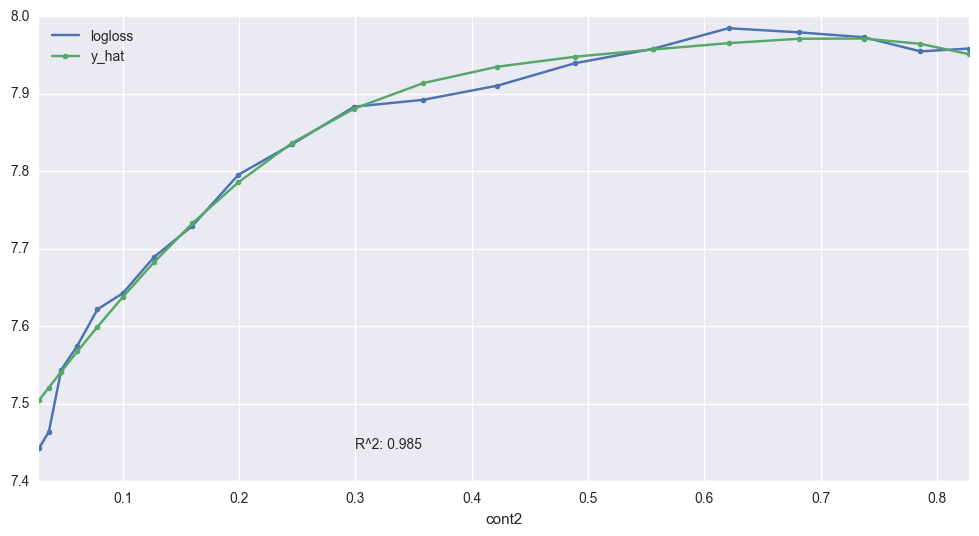

In [143]:
clean_binned['y_hat'] = poly(clean_binned.cont2)+.033*np.sin(2*np.pi*(clean_binned.cont2-.047897)/0.689171)
clean_binned['resid'] = clean_binned.logloss - clean_binned.y_hat
print clean_binned
r2 = r2_score(clean_binned.logloss, clean_binned.y_hat)

fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111)
clean_binned.plot('cont2','logloss', marker='o', ms=4, ax=ax)
clean_binned.plot('cont2', 'y_hat', marker='o', ms=4, ax=ax)
ax.text(.3, clean_binned['logloss'].min(), "R^2: {:.3f}".format(r2))
plt.show()

In [139]:
.737068-.047897

0.689171

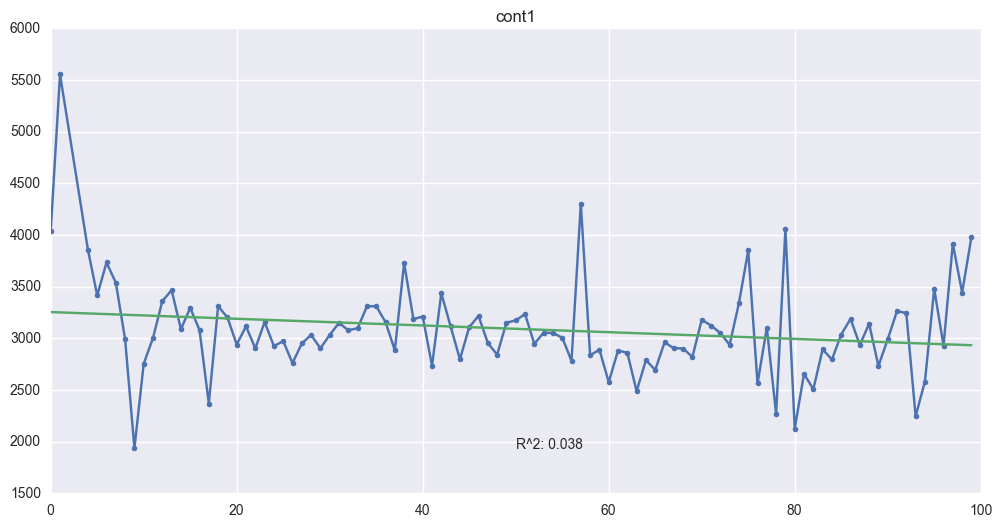

In [176]:
bins=100
plot_cont_feature_bins(bins, ['cont1'], 
                       y='loss', 
                       lin=False,
                       transform=None)#lambda x:np.power(x-.001, .13)-7.45,
                       #outliers=[0,-1])